In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py

In [2]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('.gitignore')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  217


['permutations/total_ring_mass=2.377339788691674e-09_radial_width=0.0005_shear_viscosity=1.0023744672545453e-10_sim_id=144_timesteps_per_output=39_',
 'permutations/total_ring_mass=2.377339788691672e-10_radial_width=0.0005_shear_viscosity=6.3245553203367685e-12_sim_id=31_timesteps_per_output=62_',
 'permutations/total_ring_mass=9.464360167202884e-10_radial_width=0.0005_shear_viscosity=2.244036908603932e-12_sim_id=91_timesteps_per_output=695_',
 'permutations/total_ring_mass=5.97160755830246e-10_radial_width=0.0005_shear_viscosity=5.636765862528913e-13_sim_id=66_timesteps_per_output=1748_',
 'permutations/total_ring_mass=1.4999999999999984e-10_radial_width=0.0005_shear_viscosity=1.7825018762674924e-11_sim_id=13_timesteps_per_output=13_']

In [3]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('_timesteps_per_output=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/total_ring_mass=1.499999999999998...
1       1  permutations/total_ring_mass=1.499999999999998...
2       2  permutations/total_ring_mass=1.499999999999998...
3       3  permutations/total_ring_mass=1.499999999999998...
4       4  permutations/total_ring_mass=1.499999999999998...

In [5]:
#set power laws for ringlet's dynamical timescale = time for e_prime to reach 0.6, which is assumed to vary as 
#(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
nominal_dynamical_timescale = 1.65e4
mass_power_law = 1.0
viscosity_power_law = -1.0
width_power_law = -0.33

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:56: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:58: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:68: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)


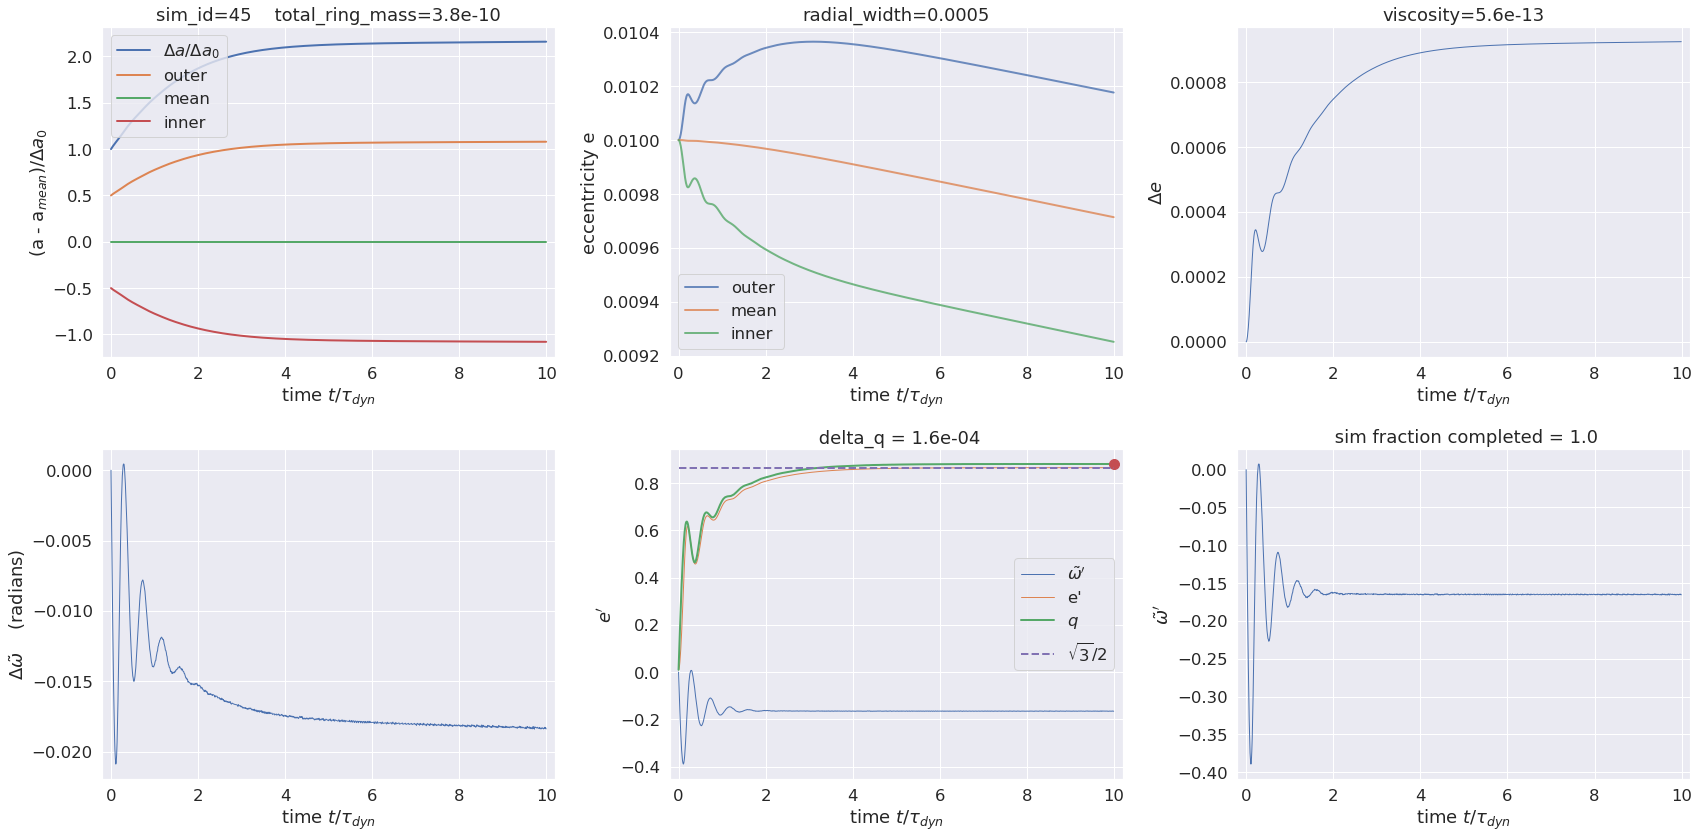

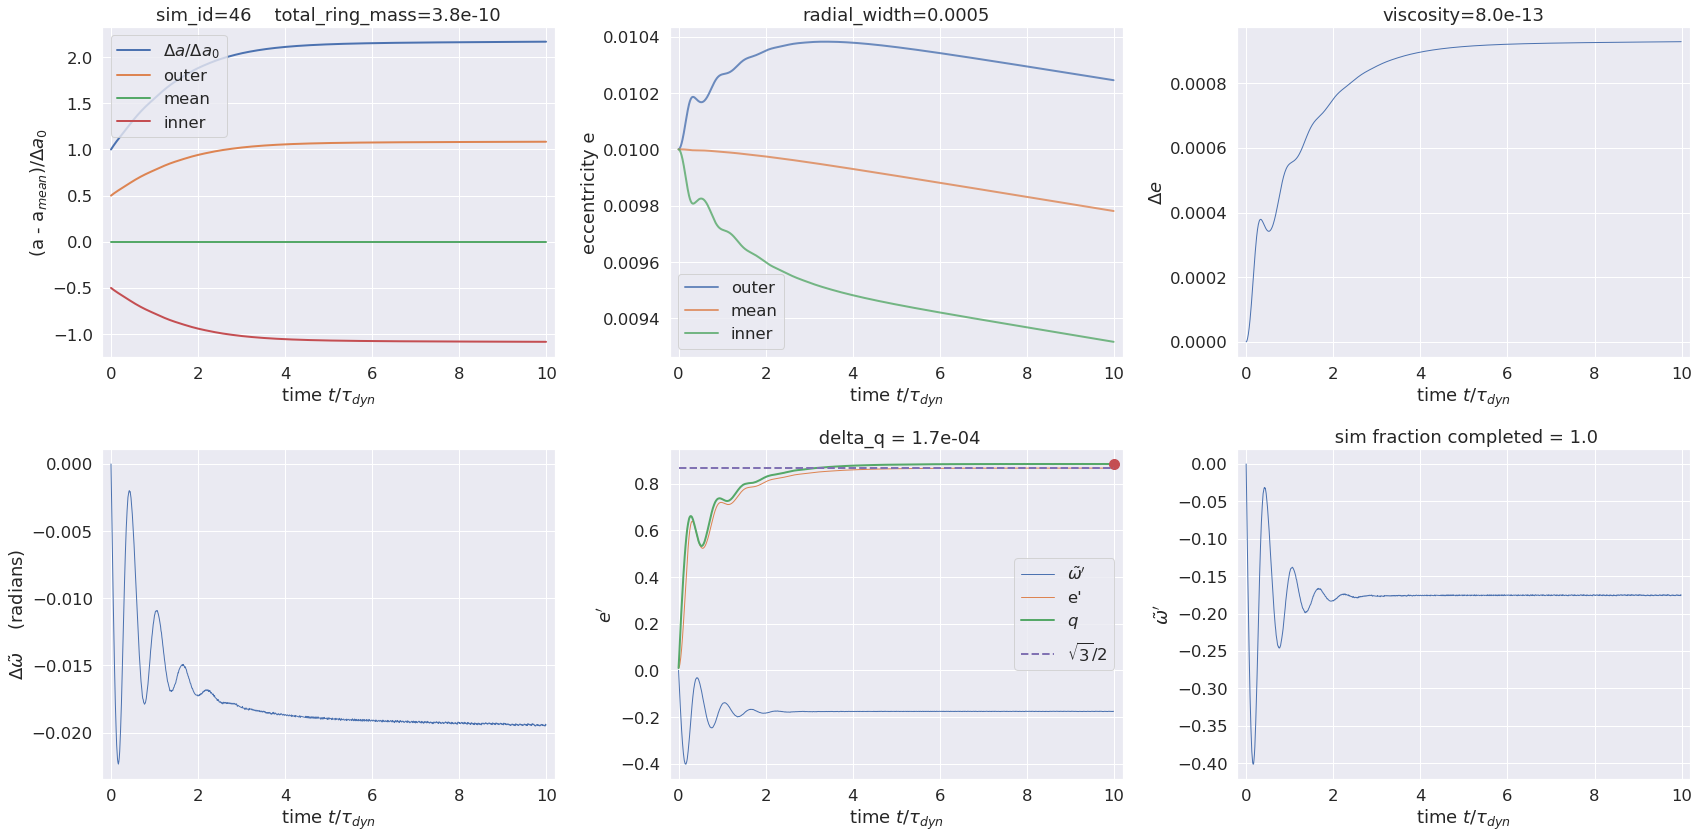

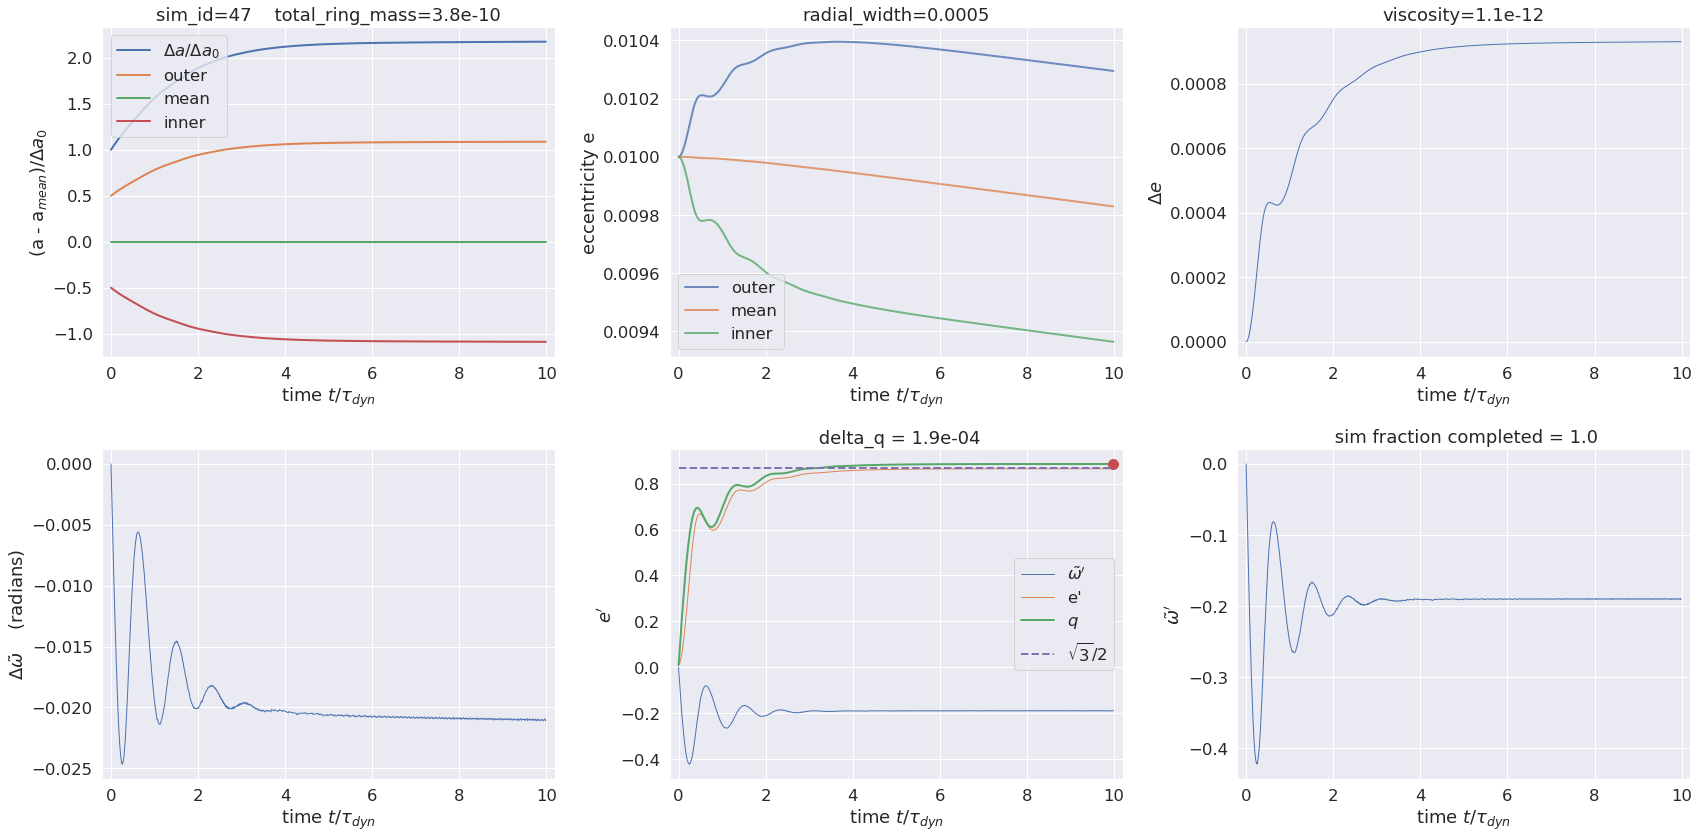

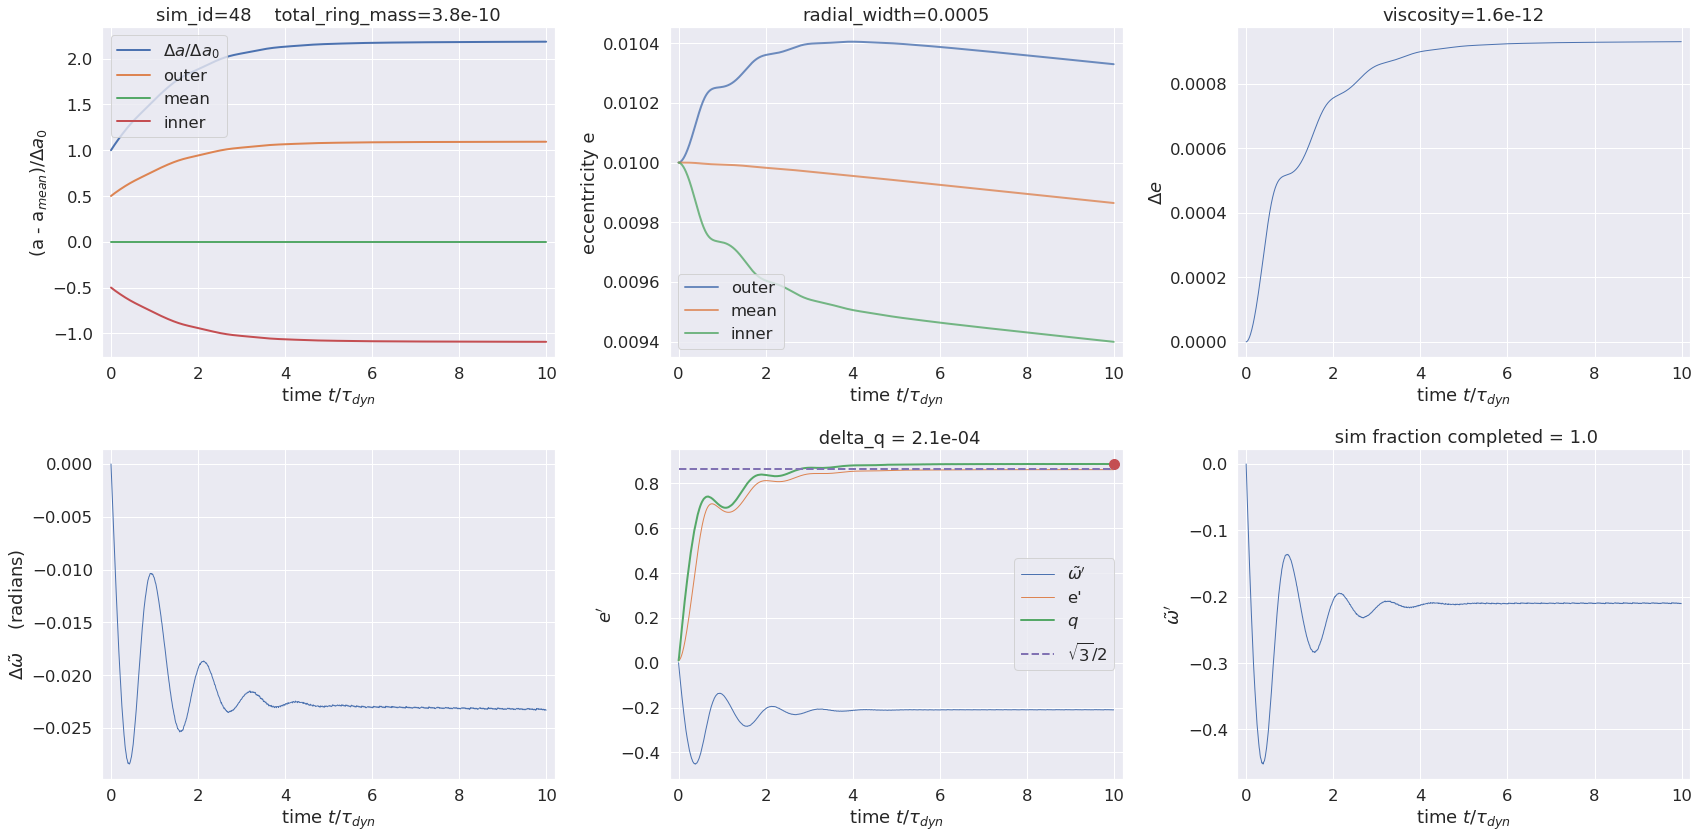

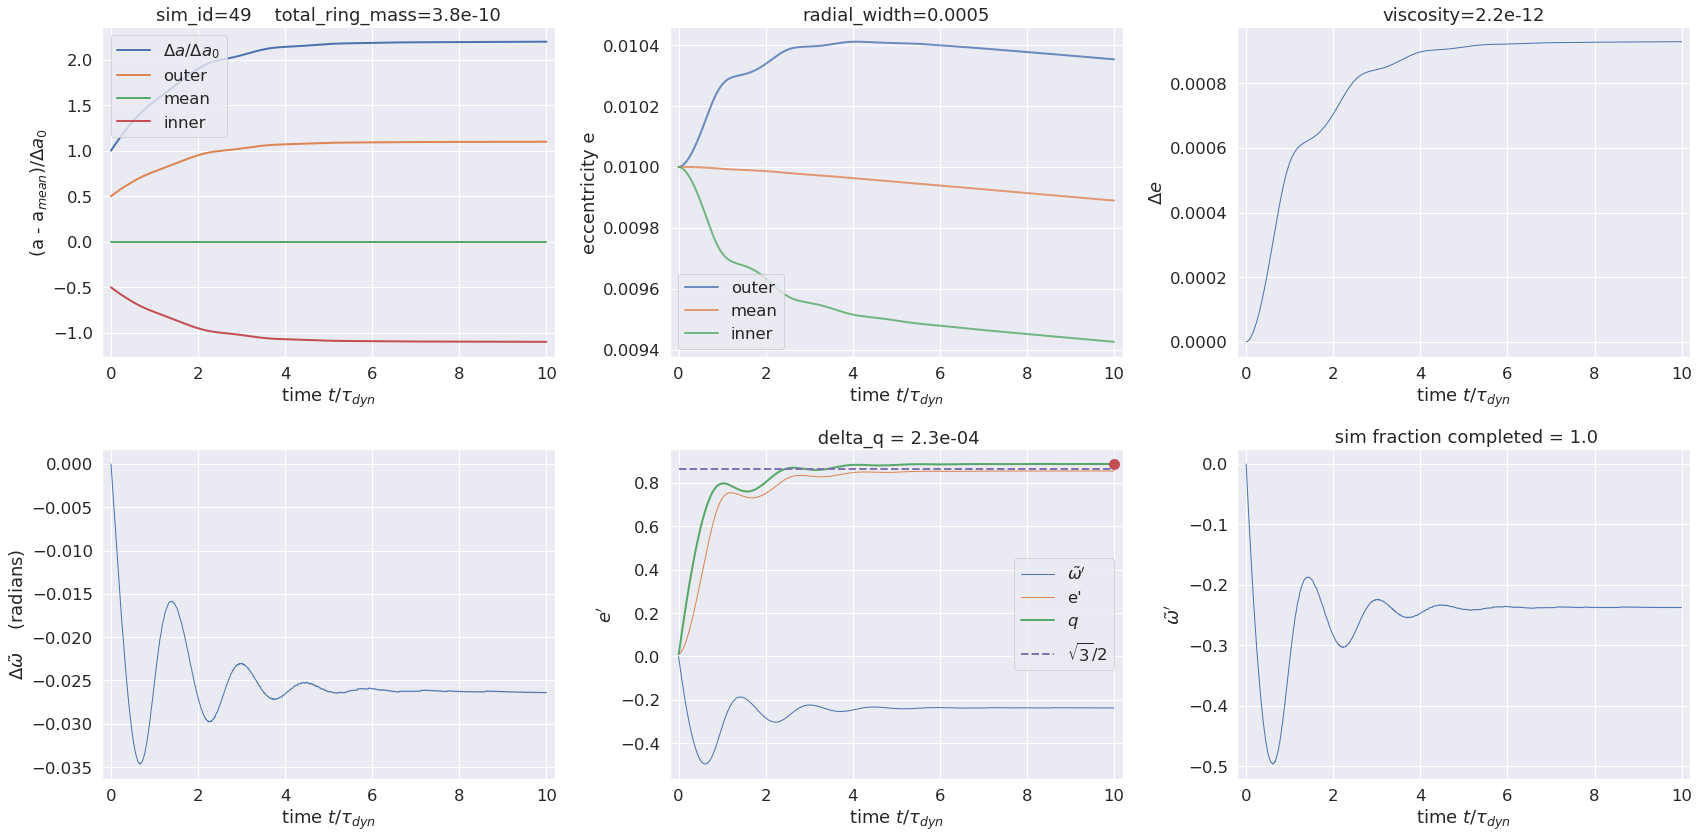

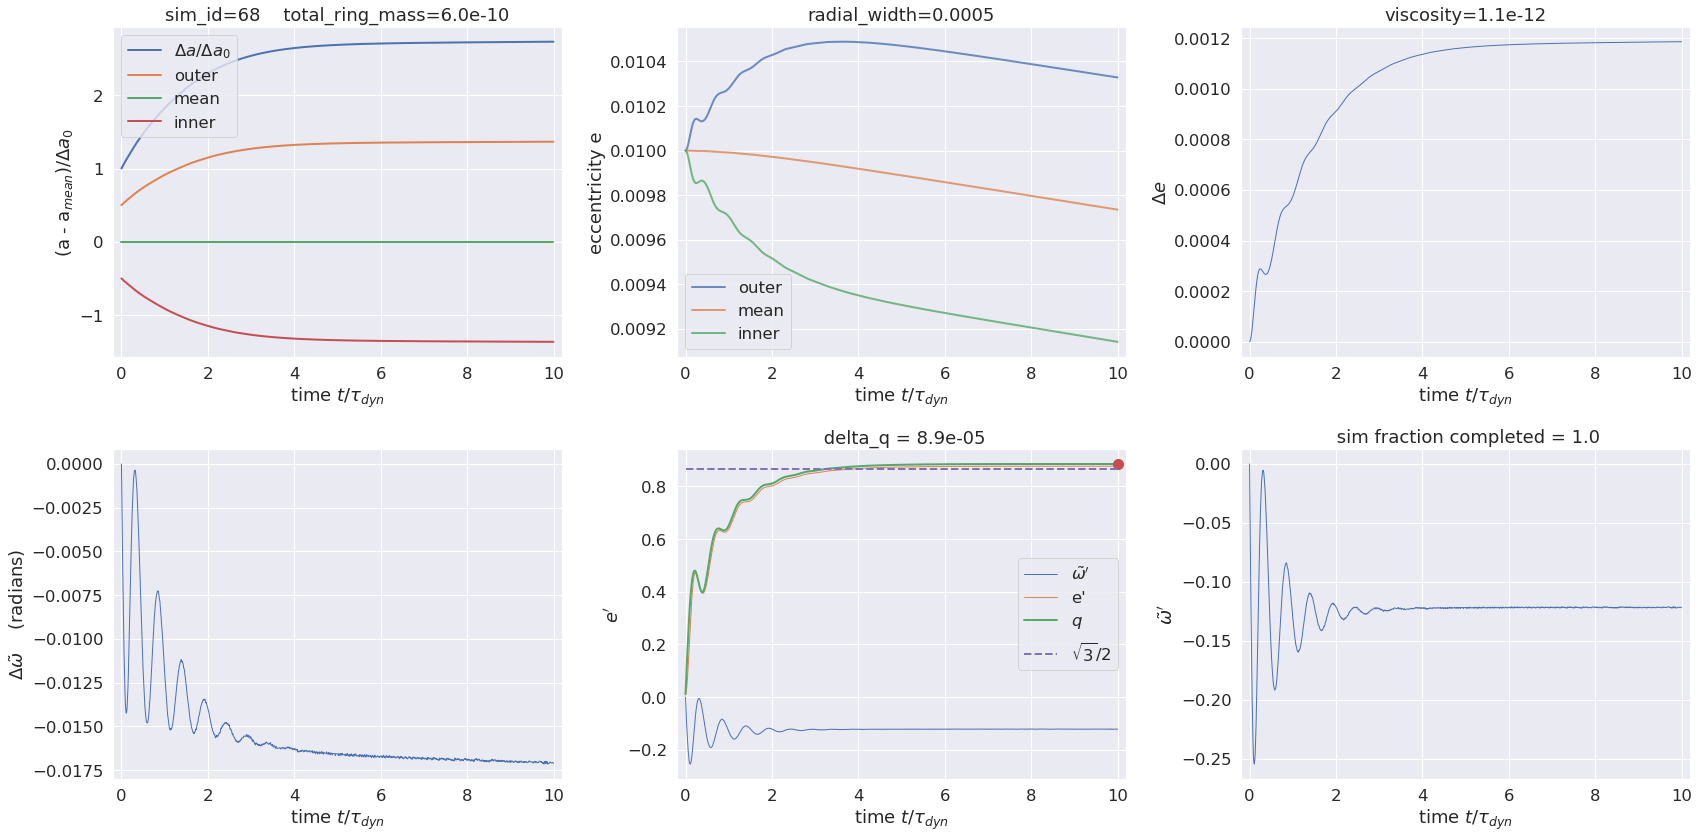

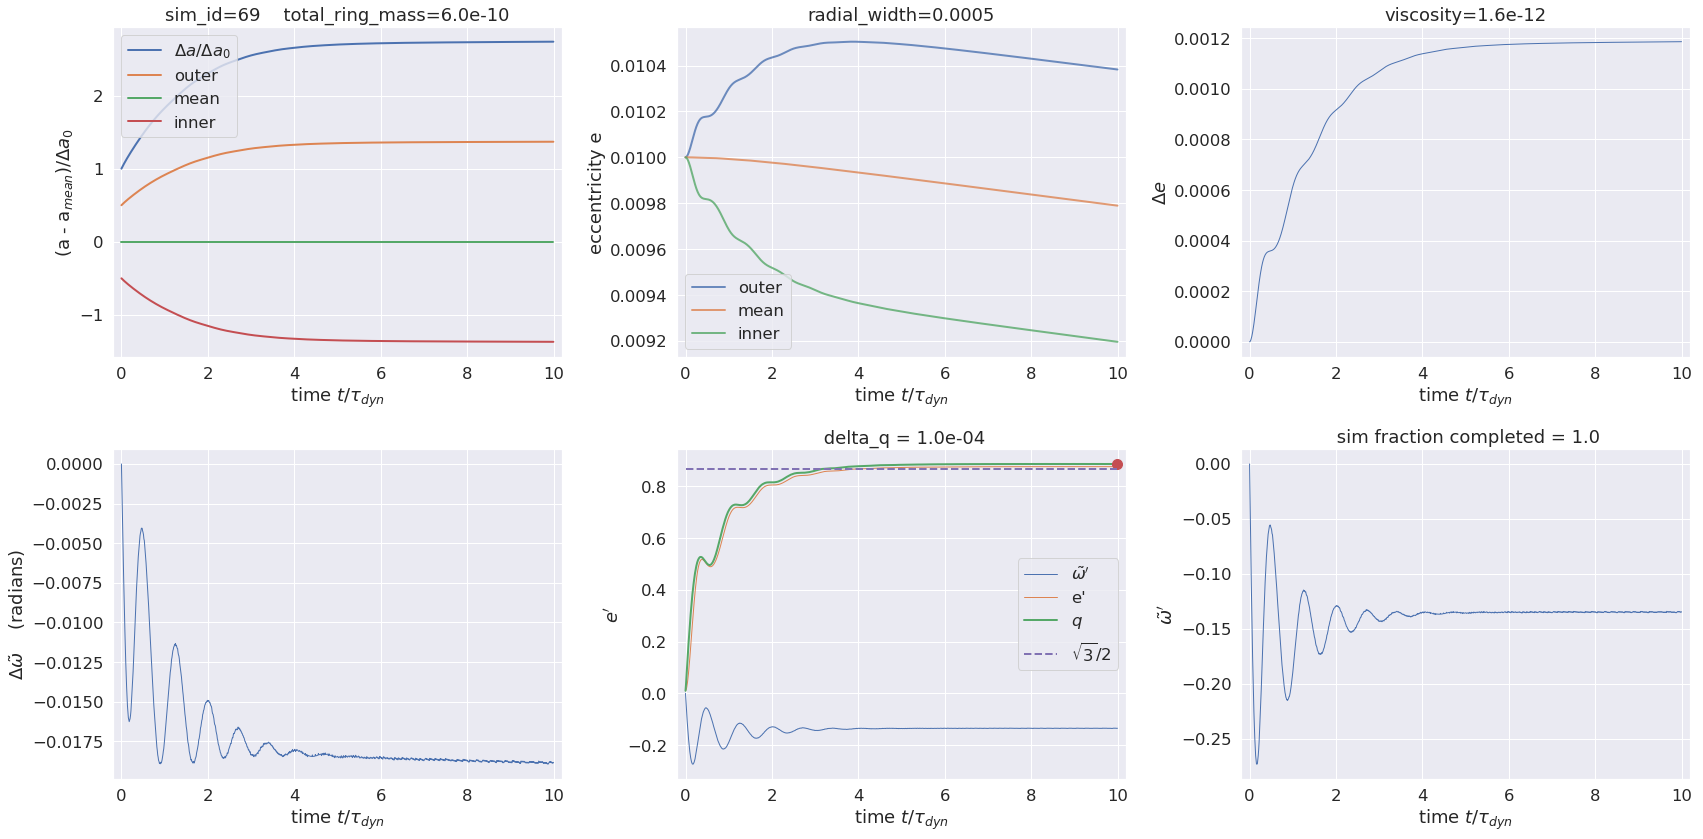

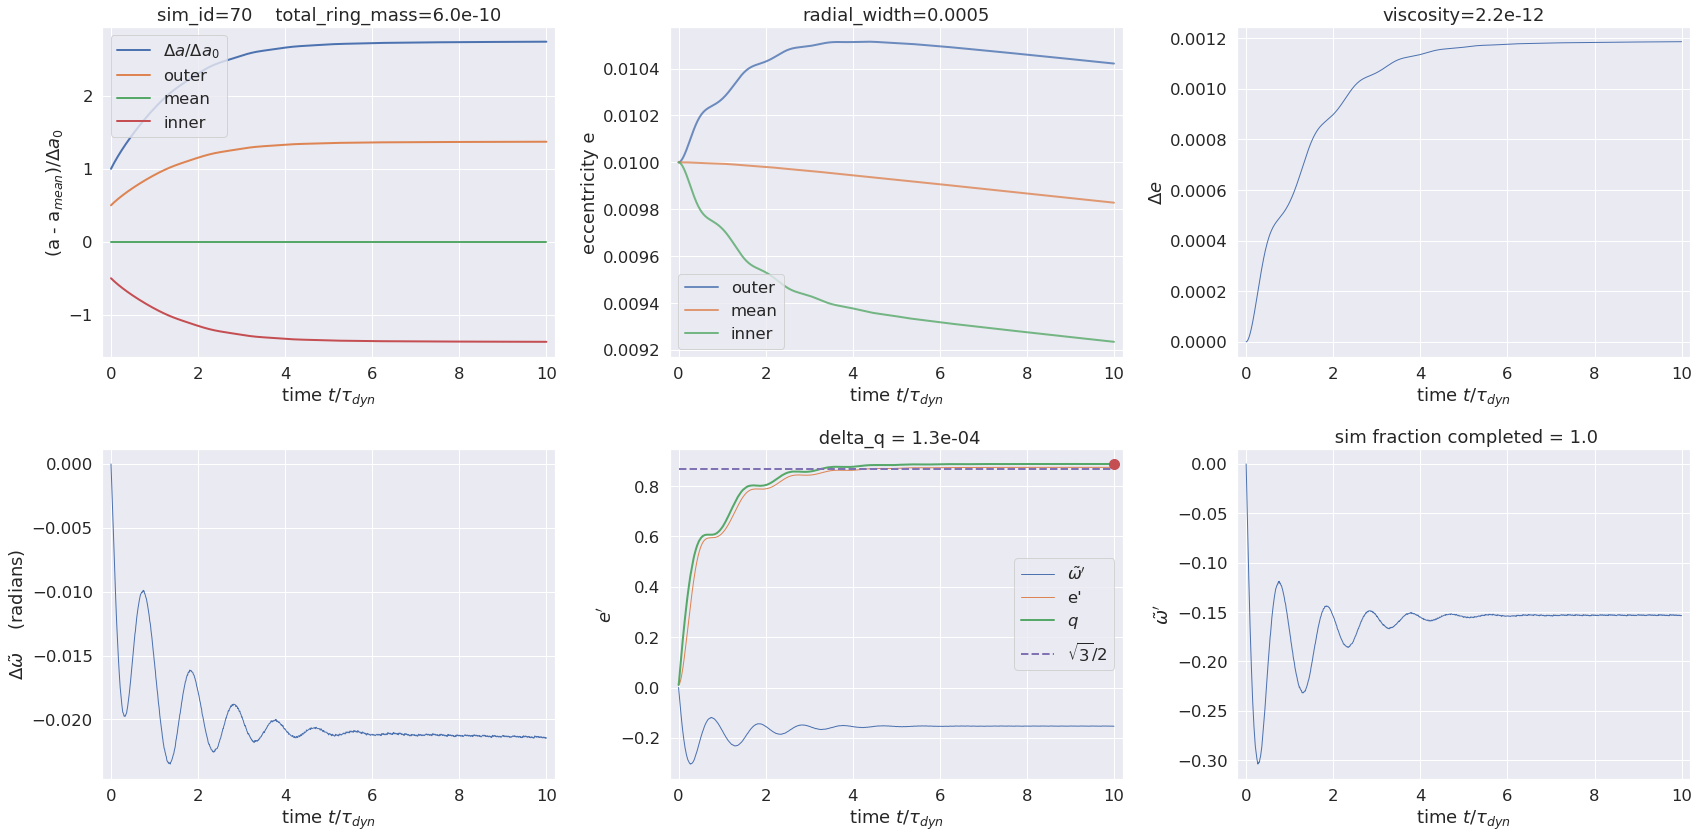

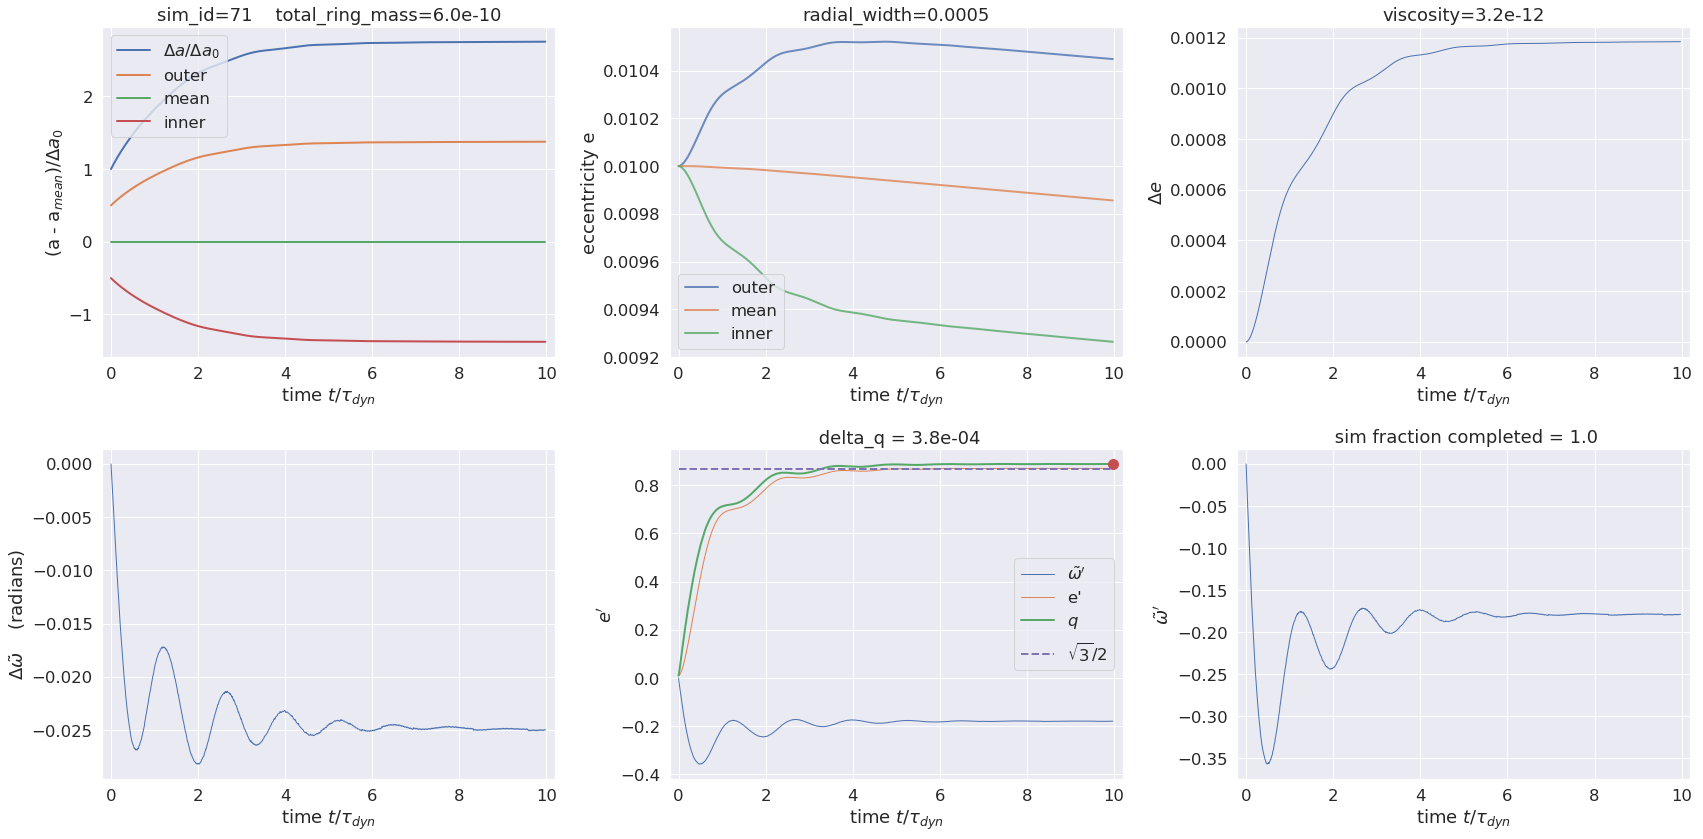

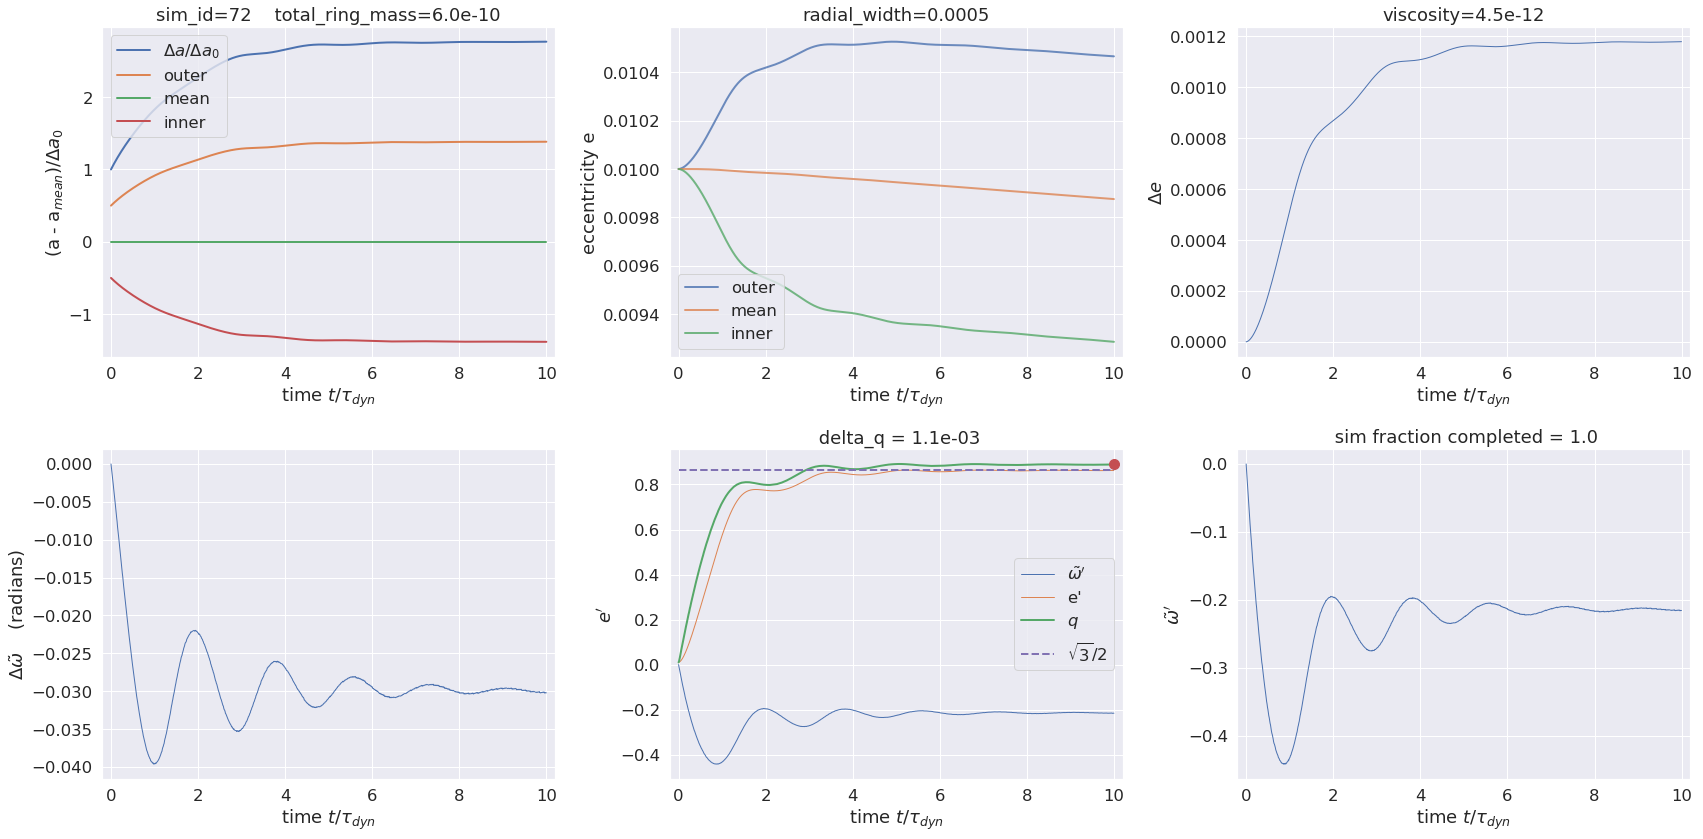

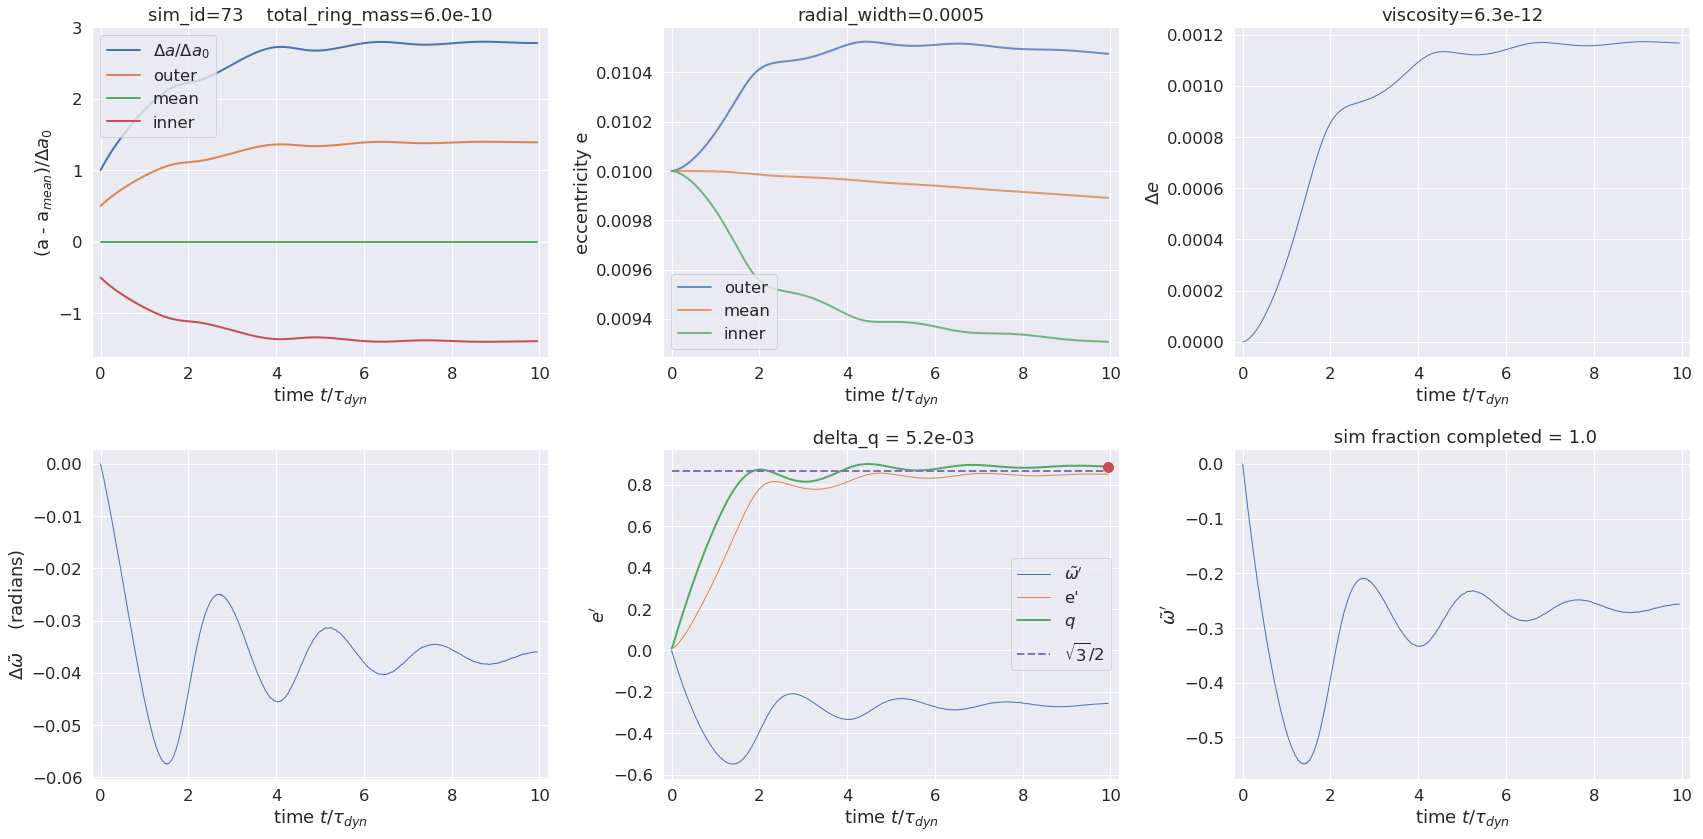

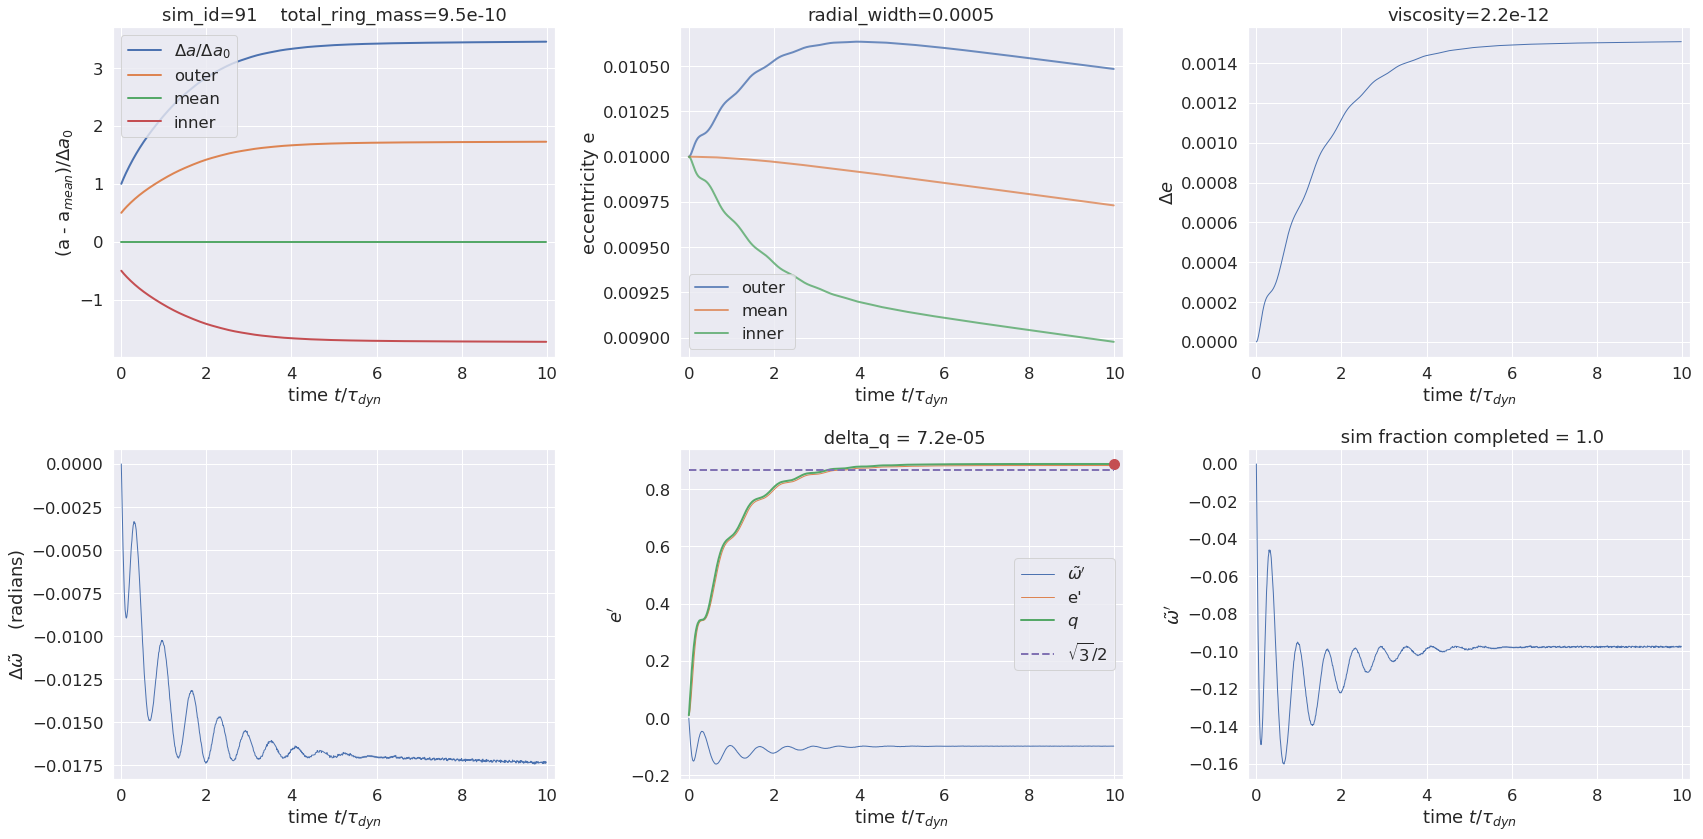

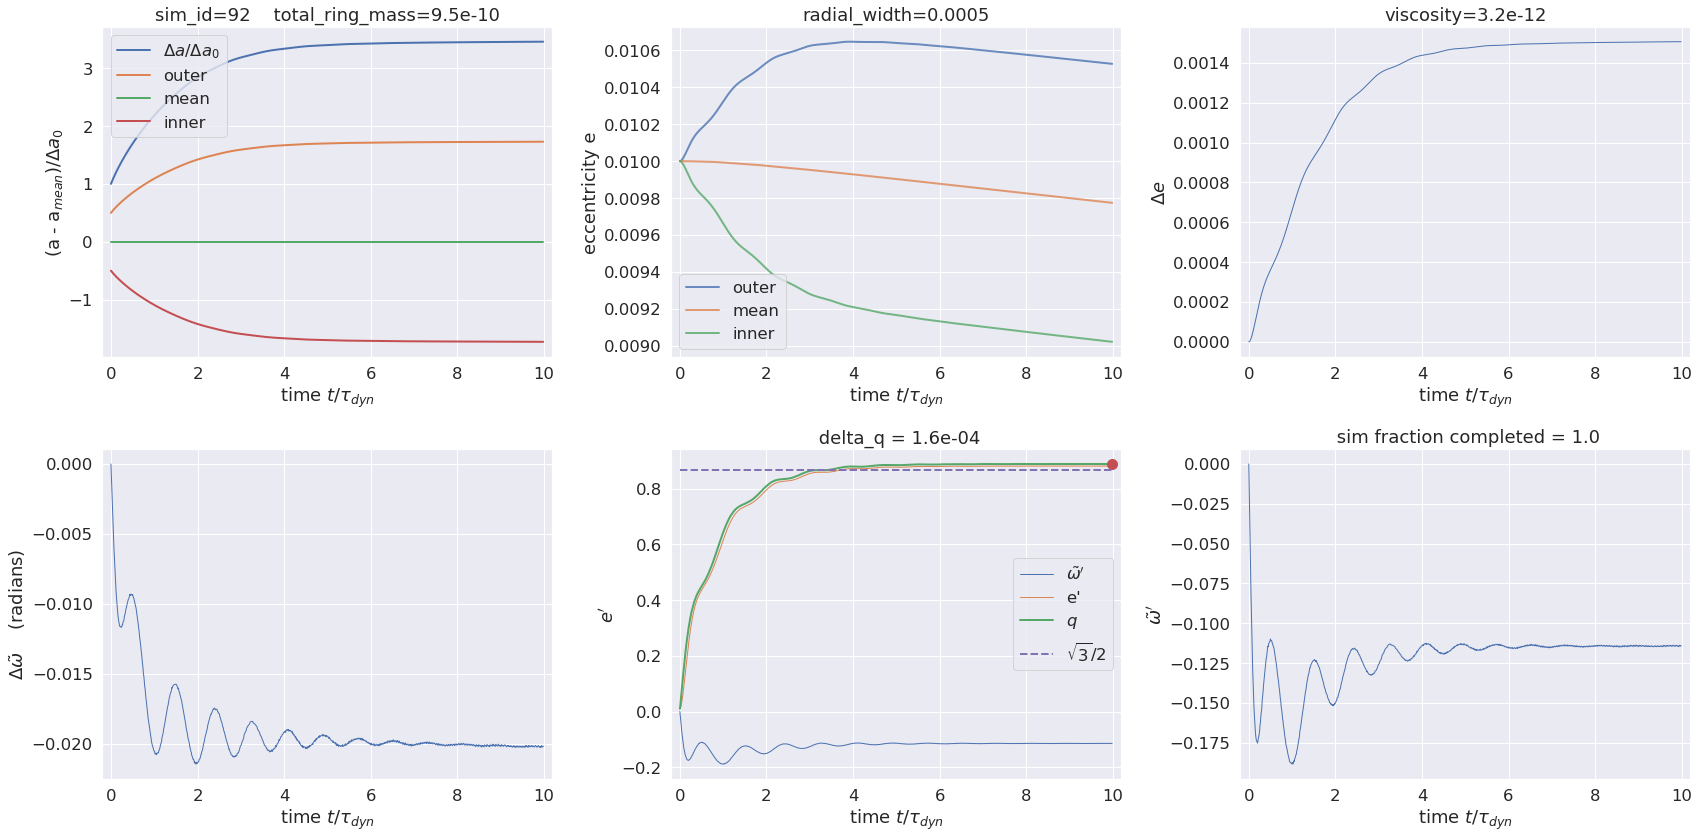

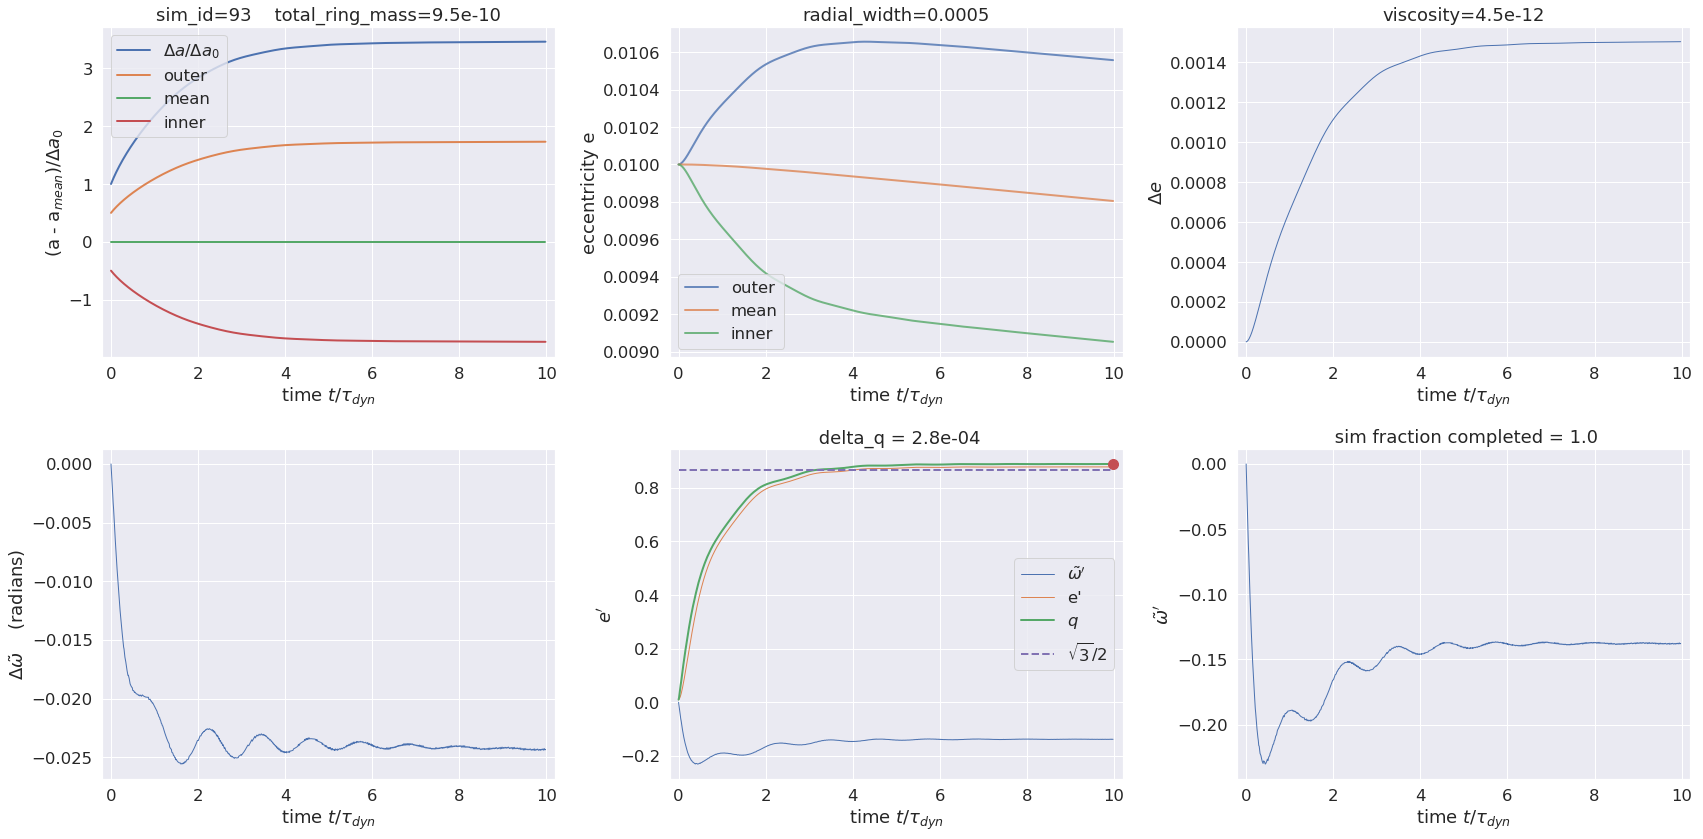

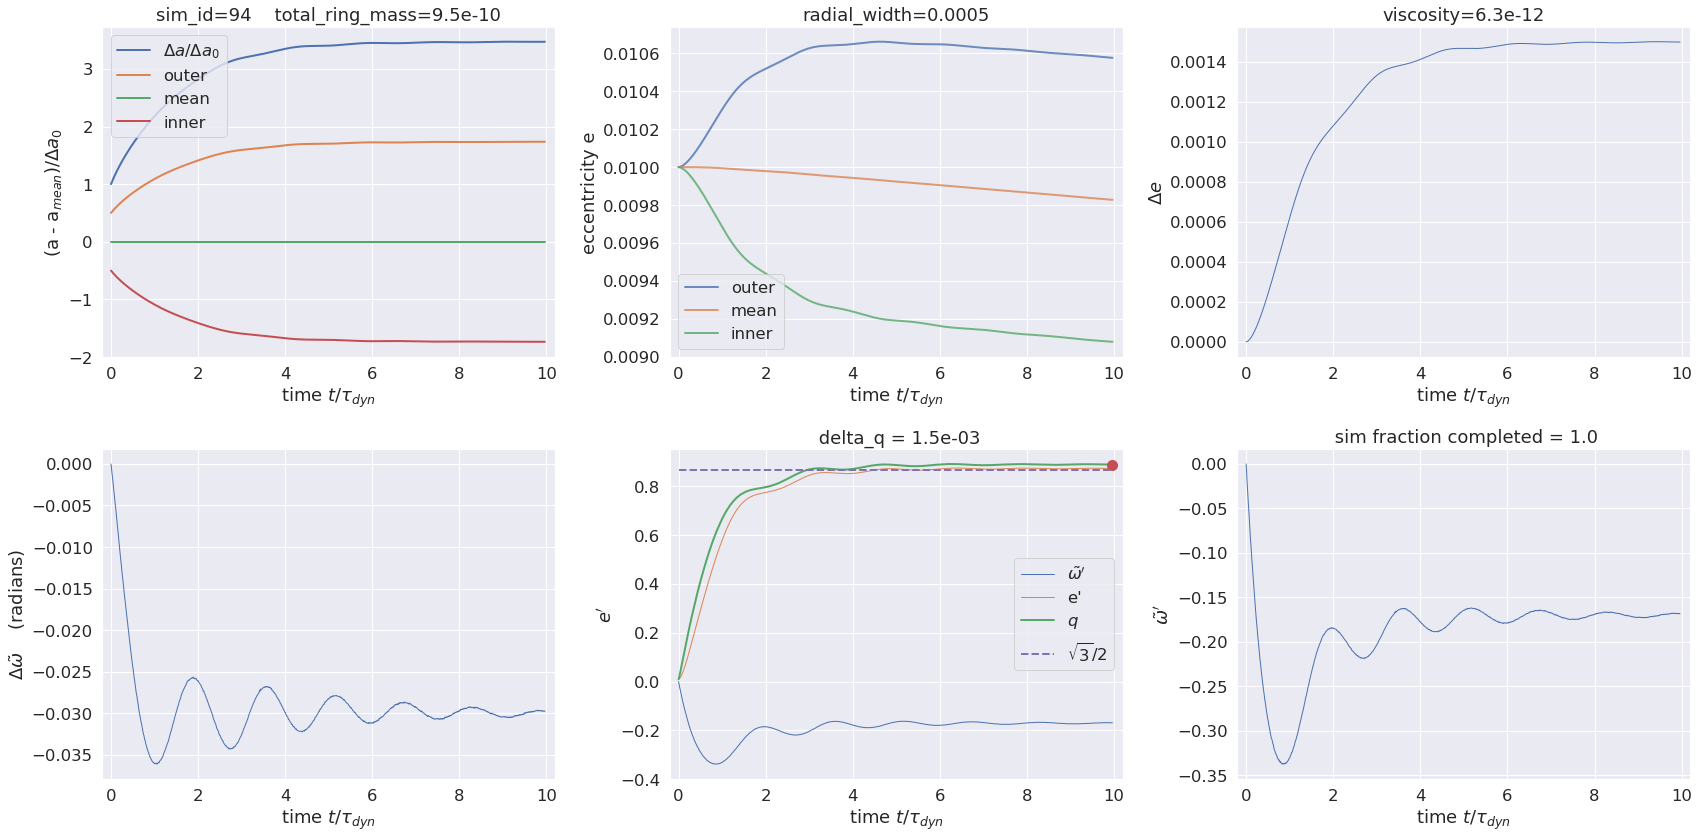

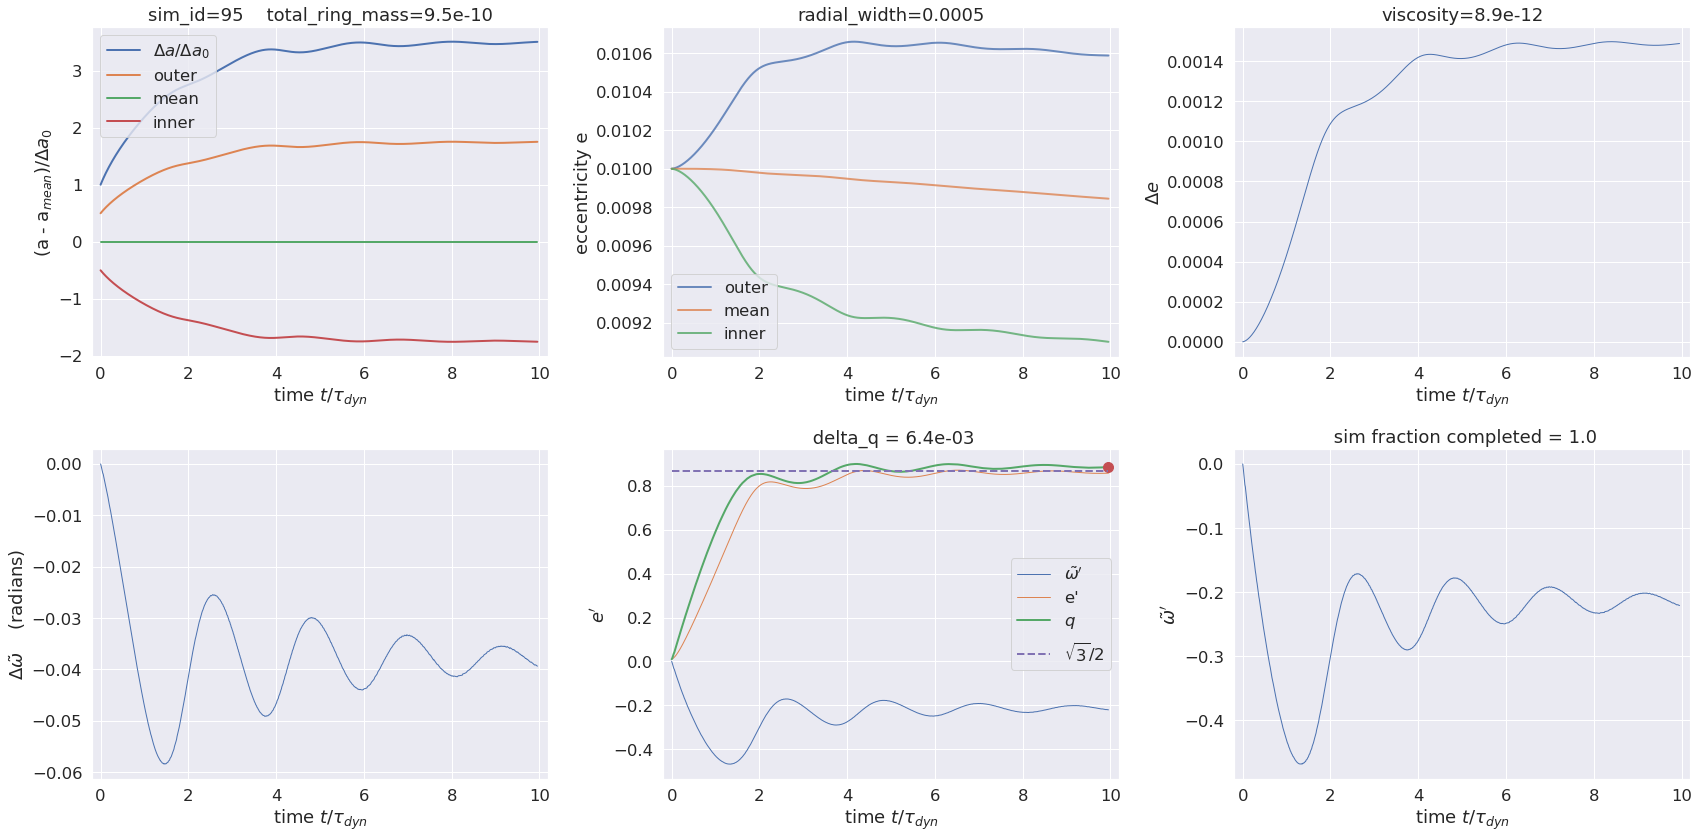

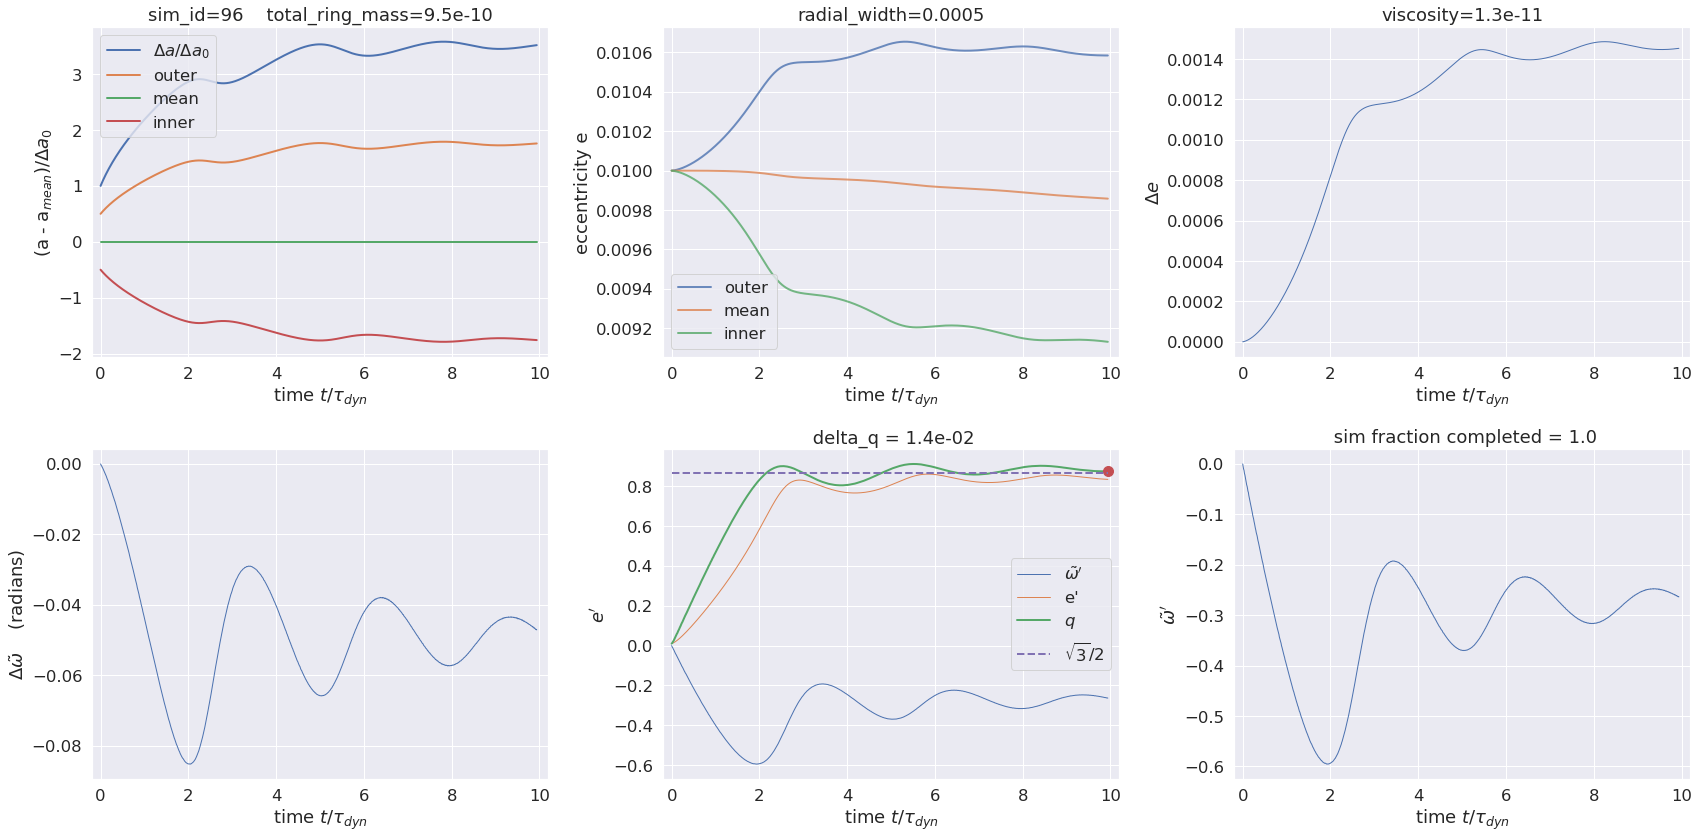

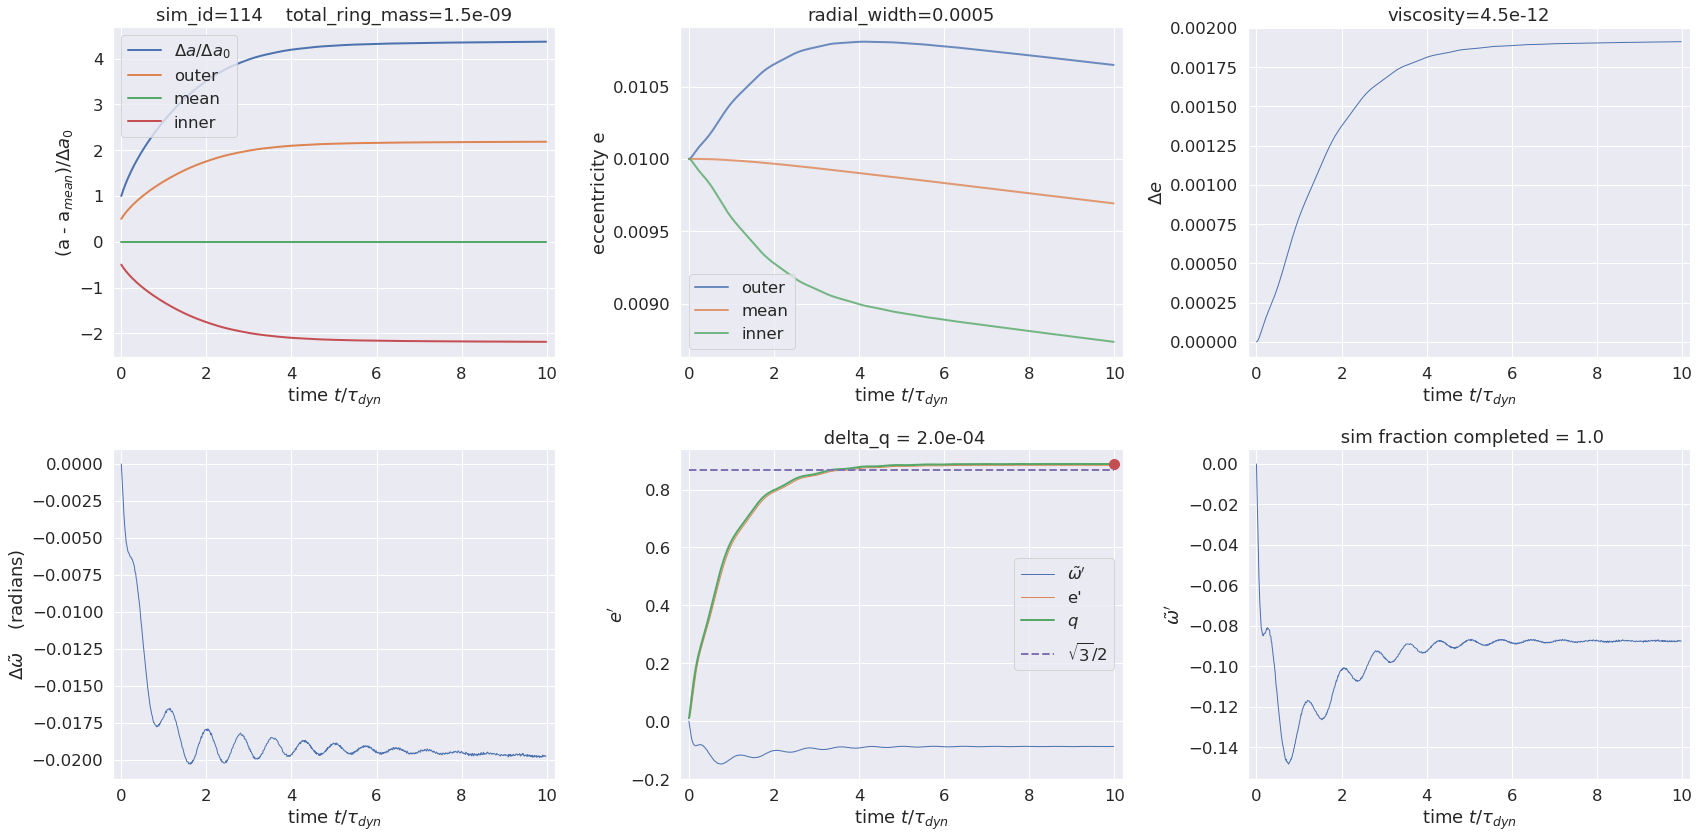

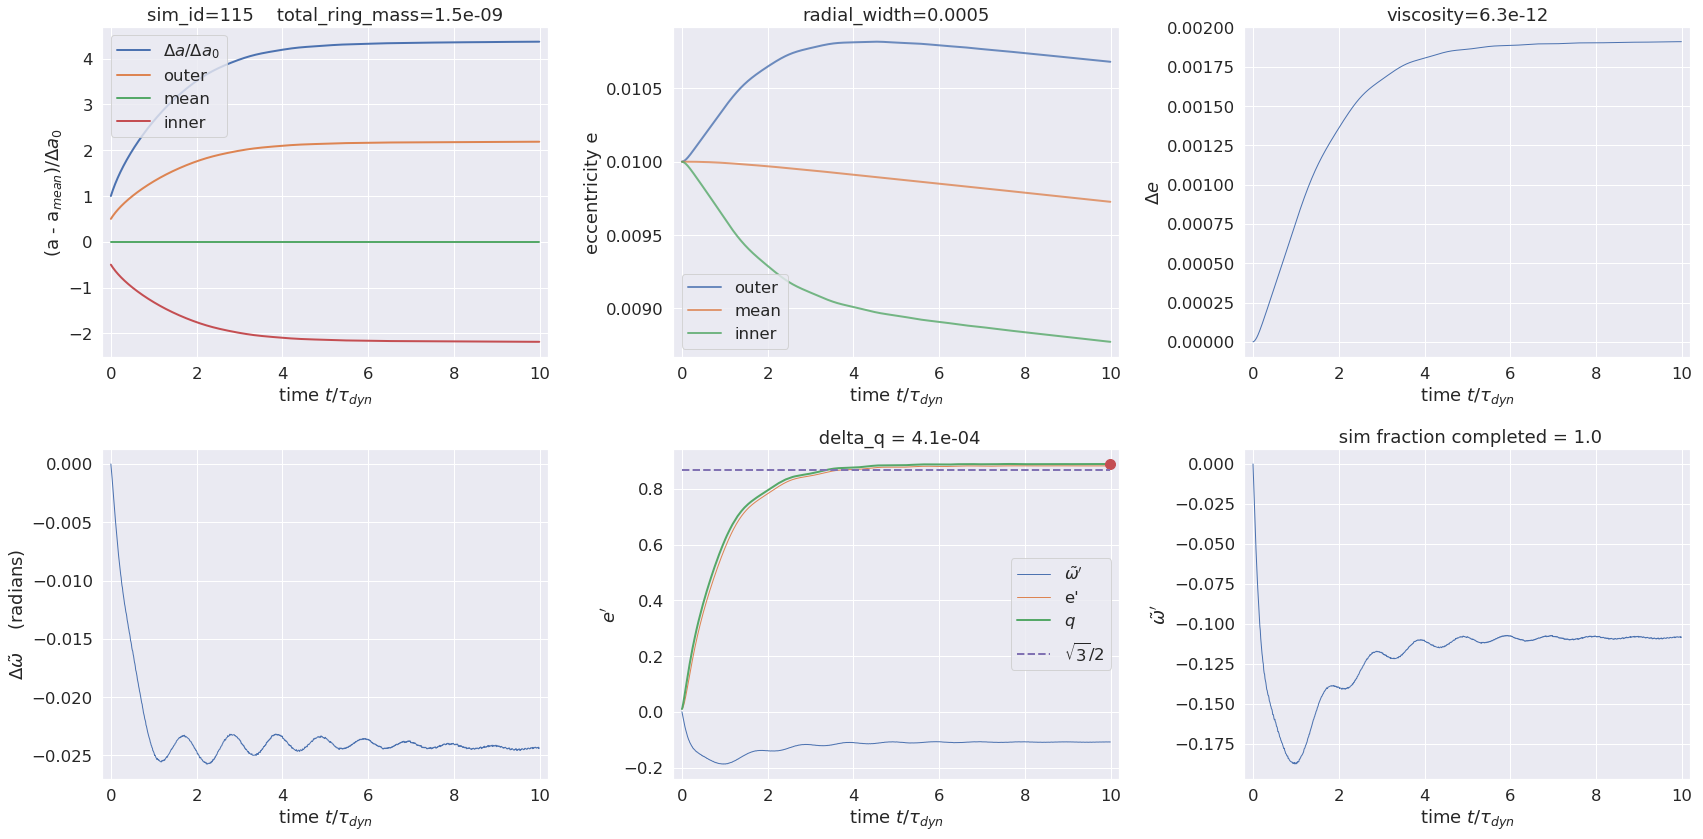

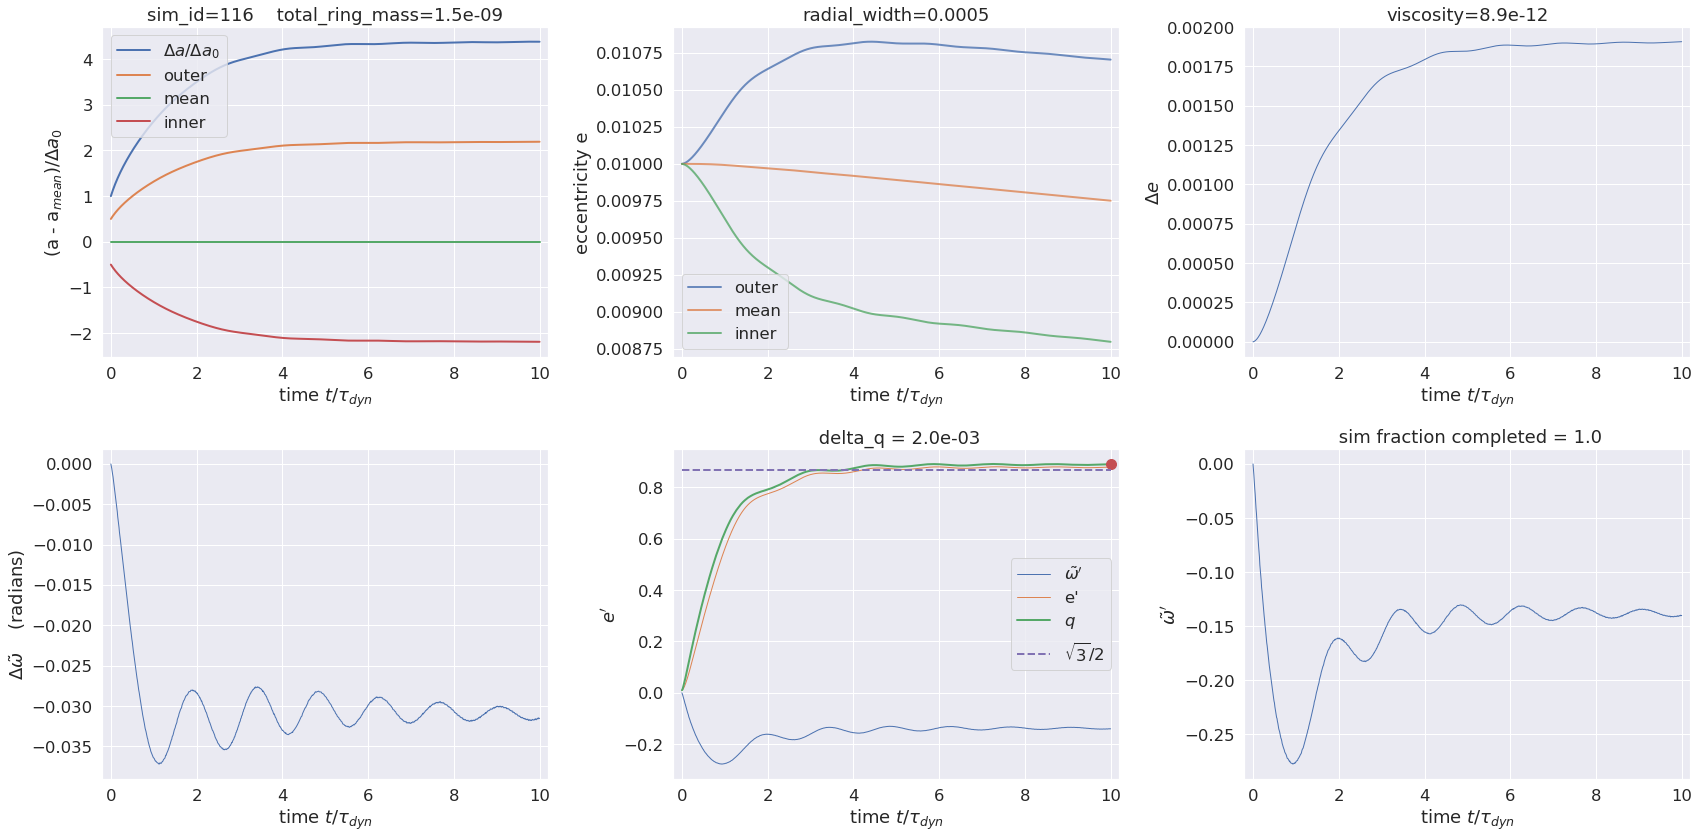

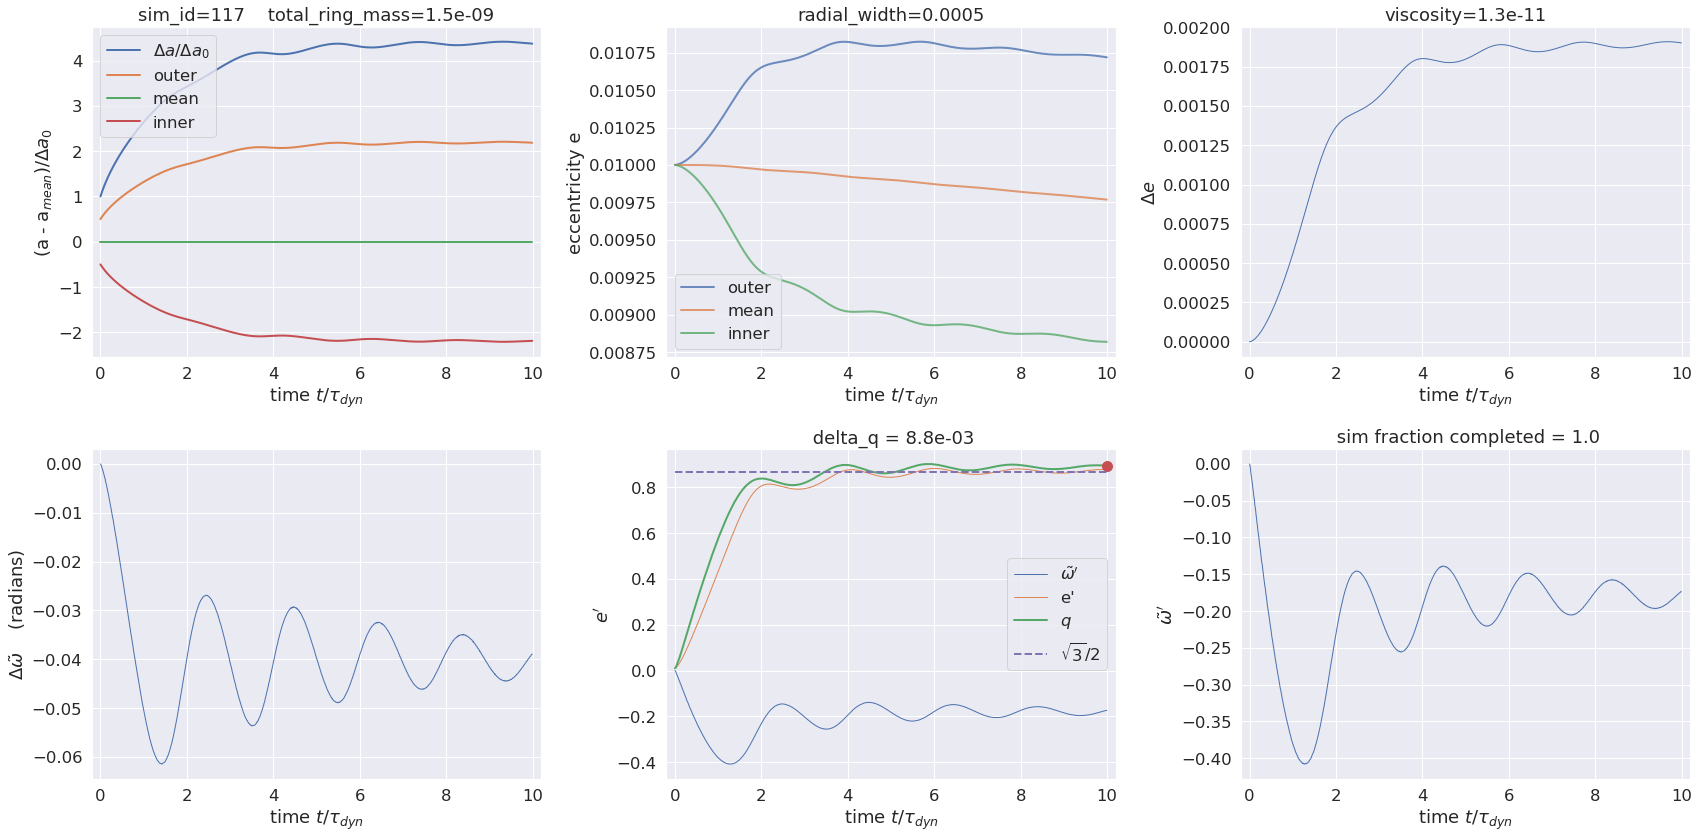

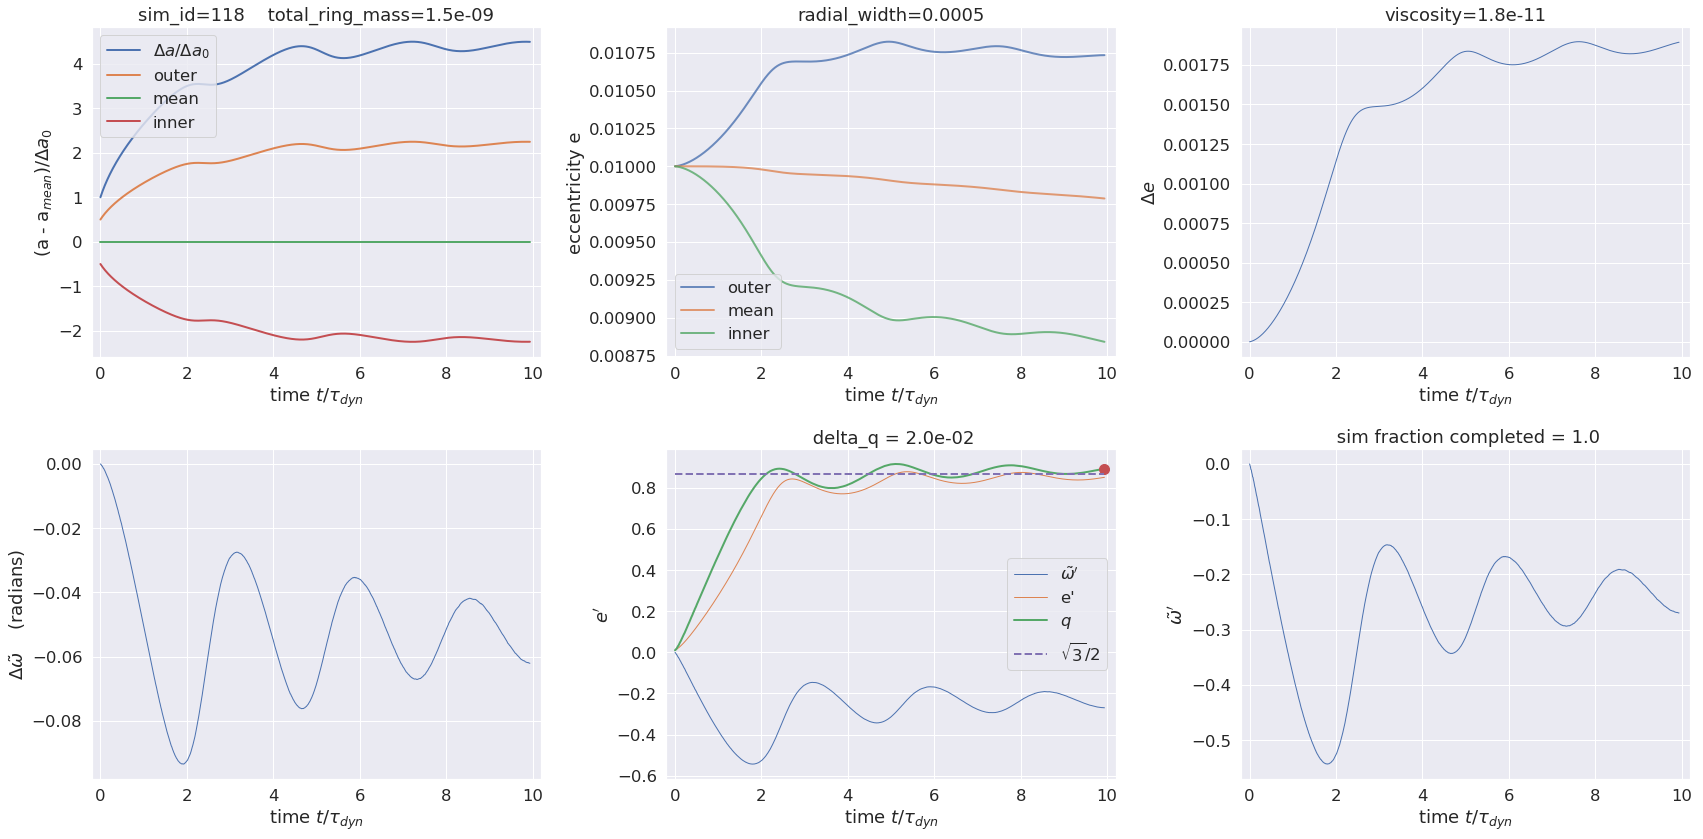

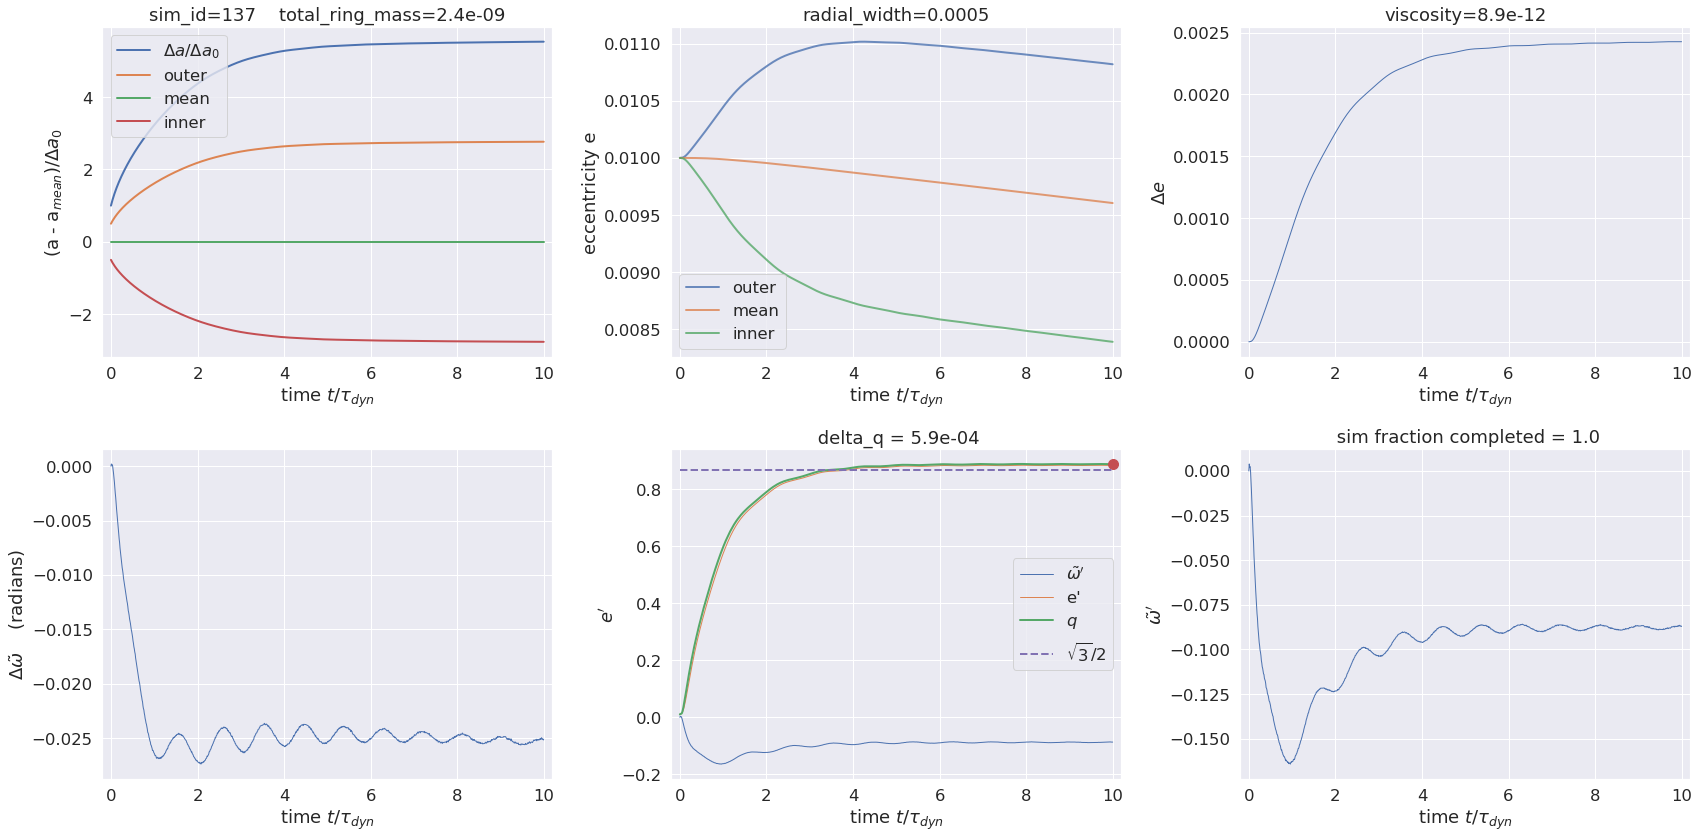

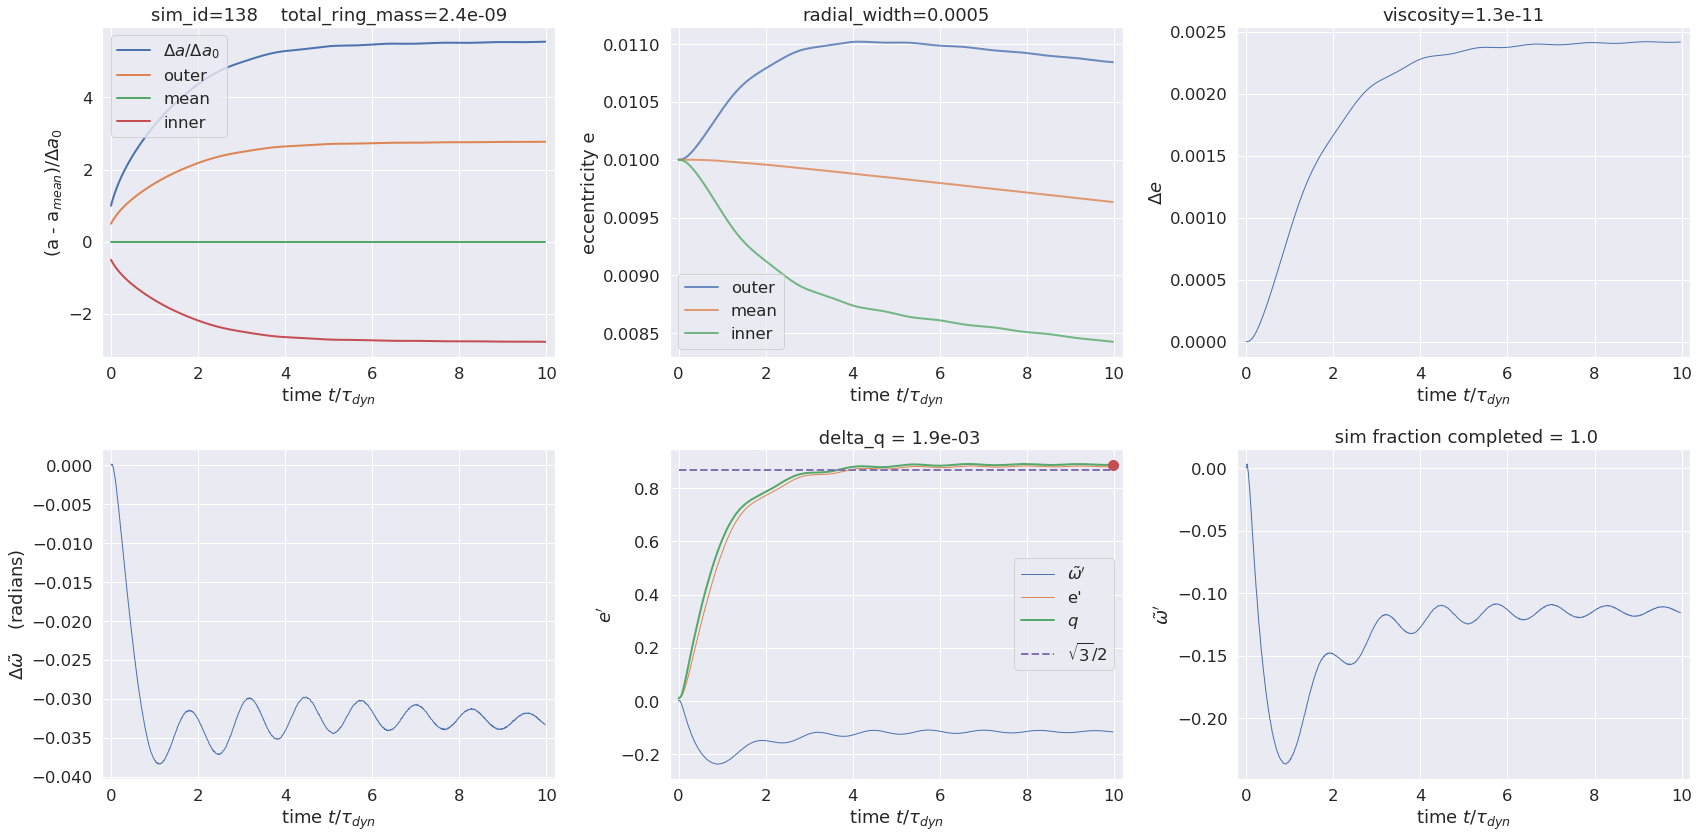

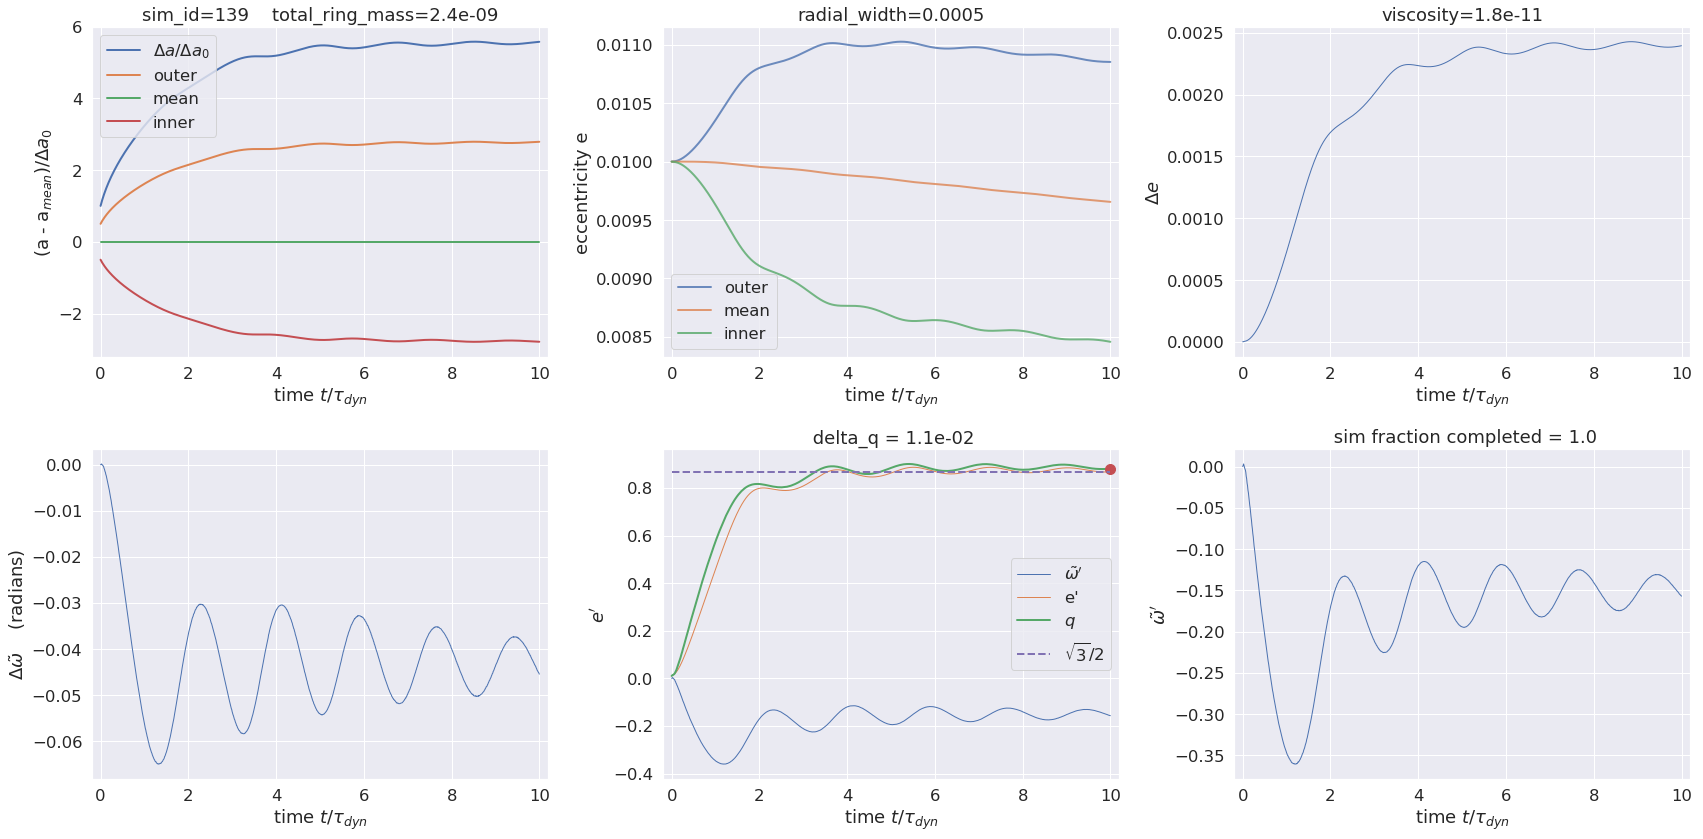

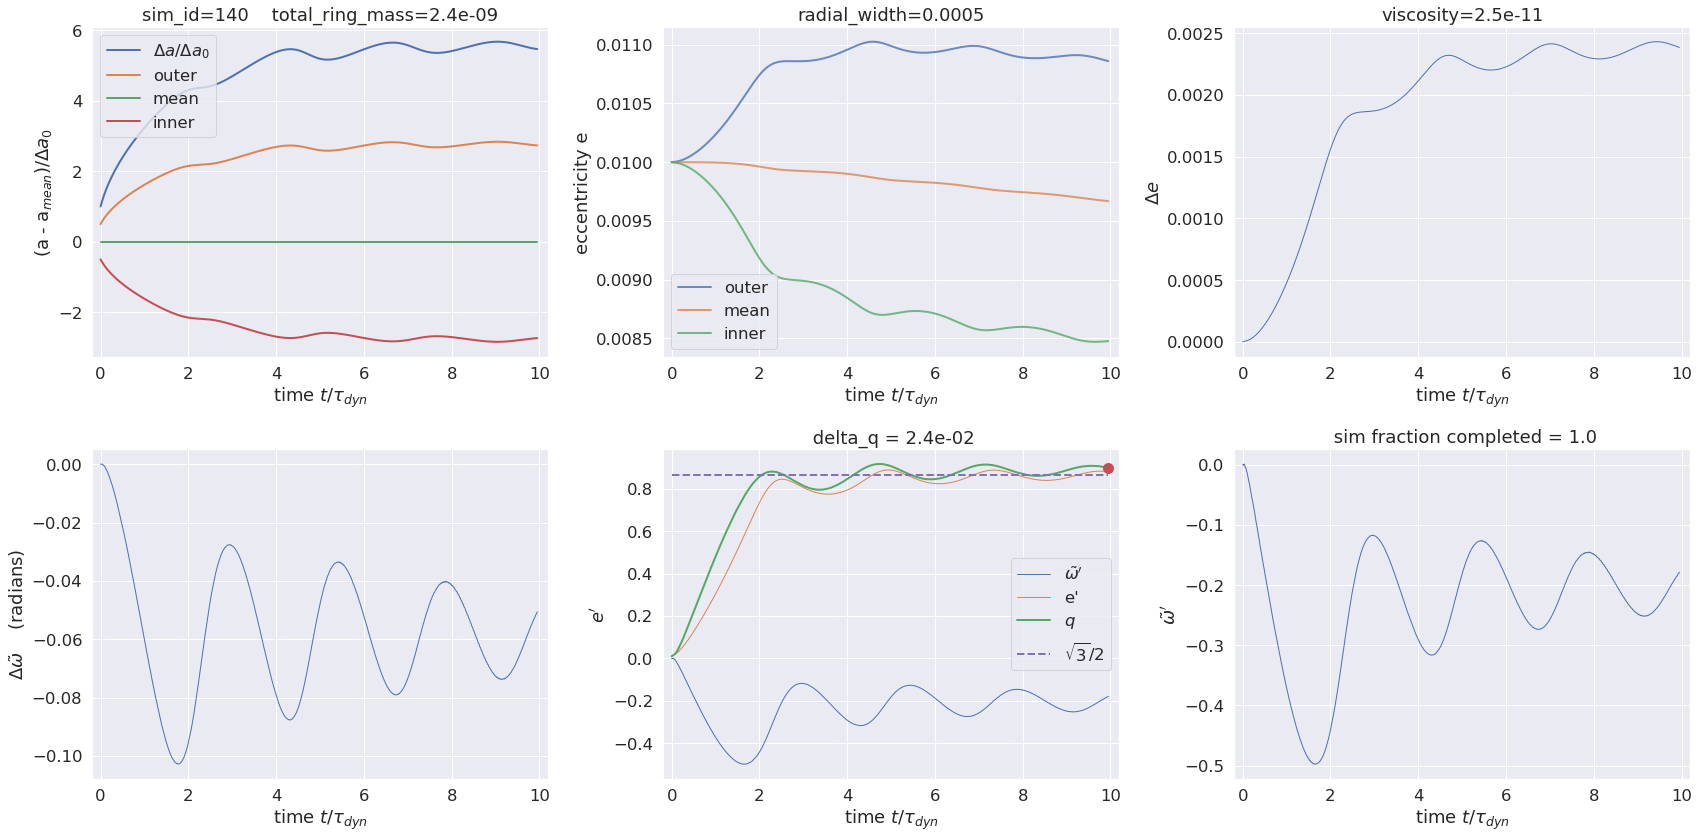

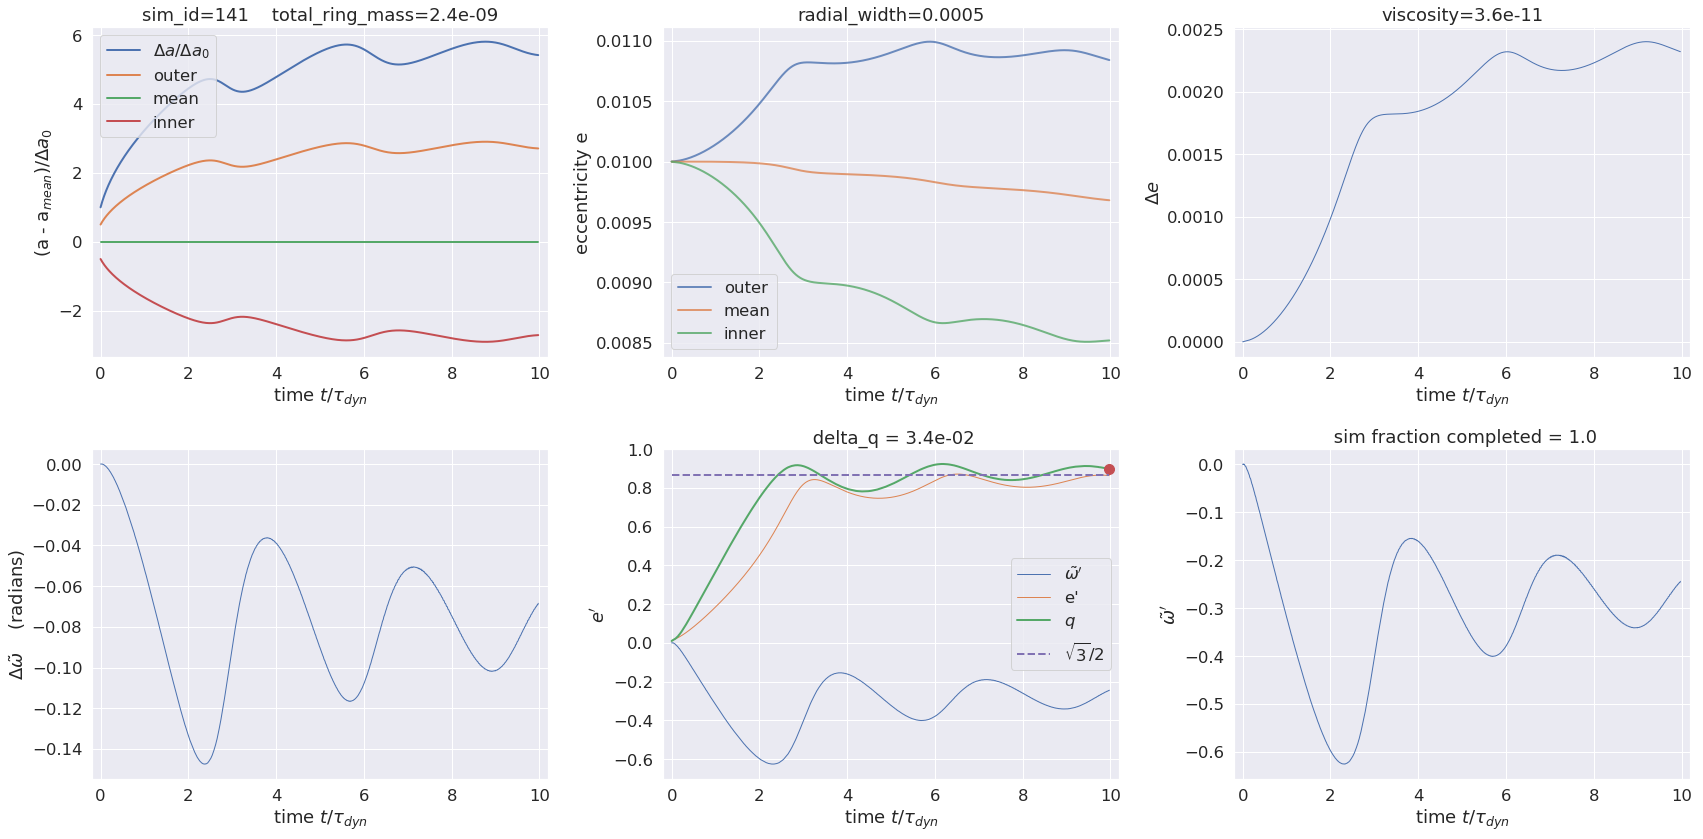

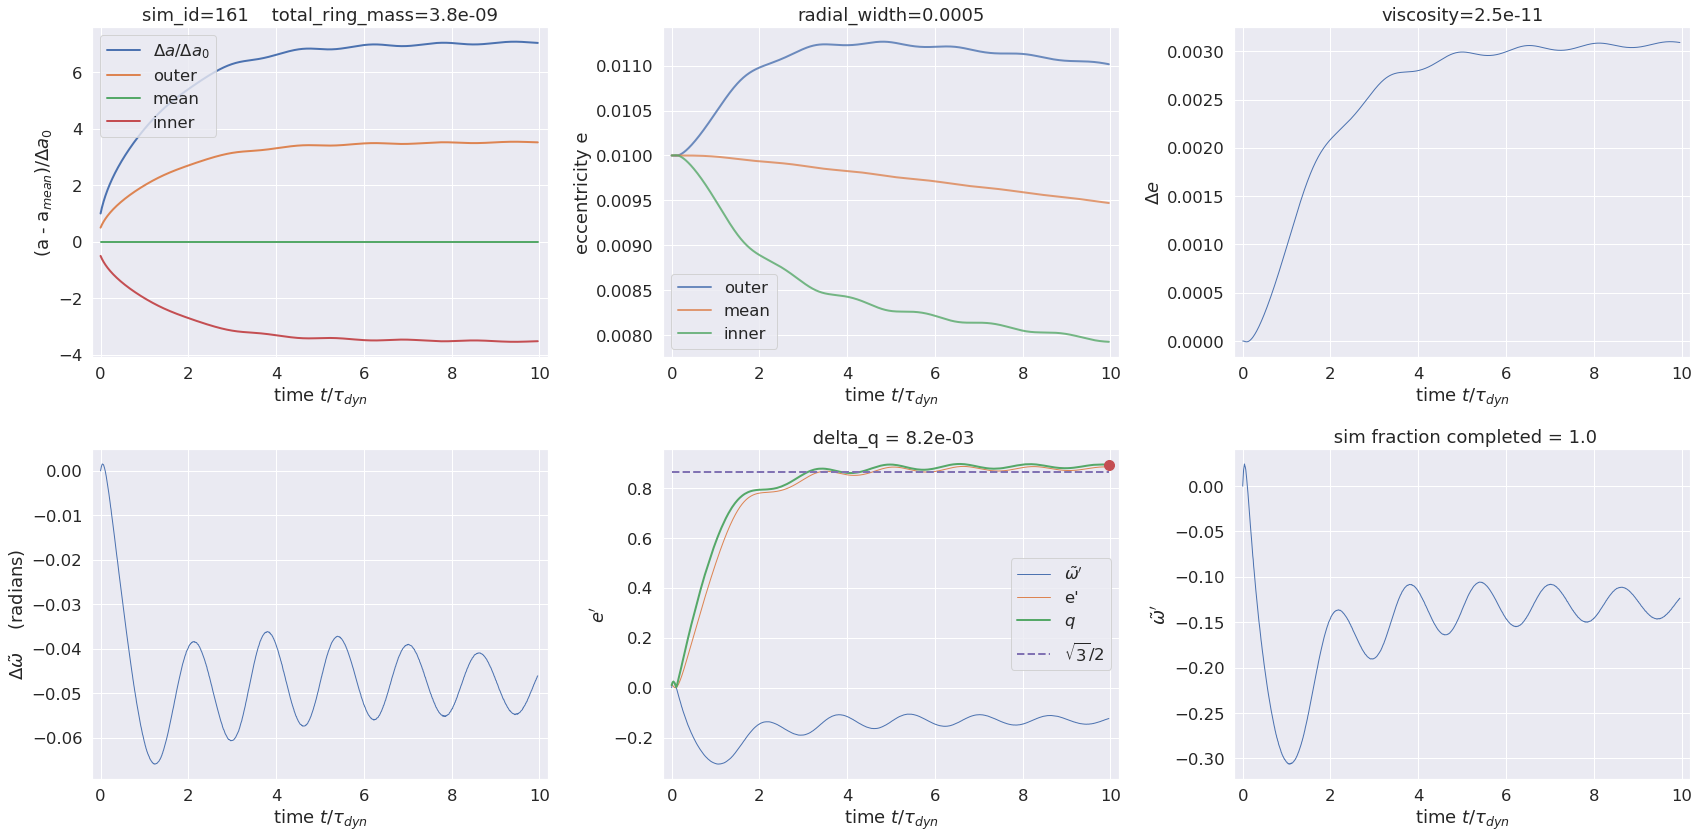

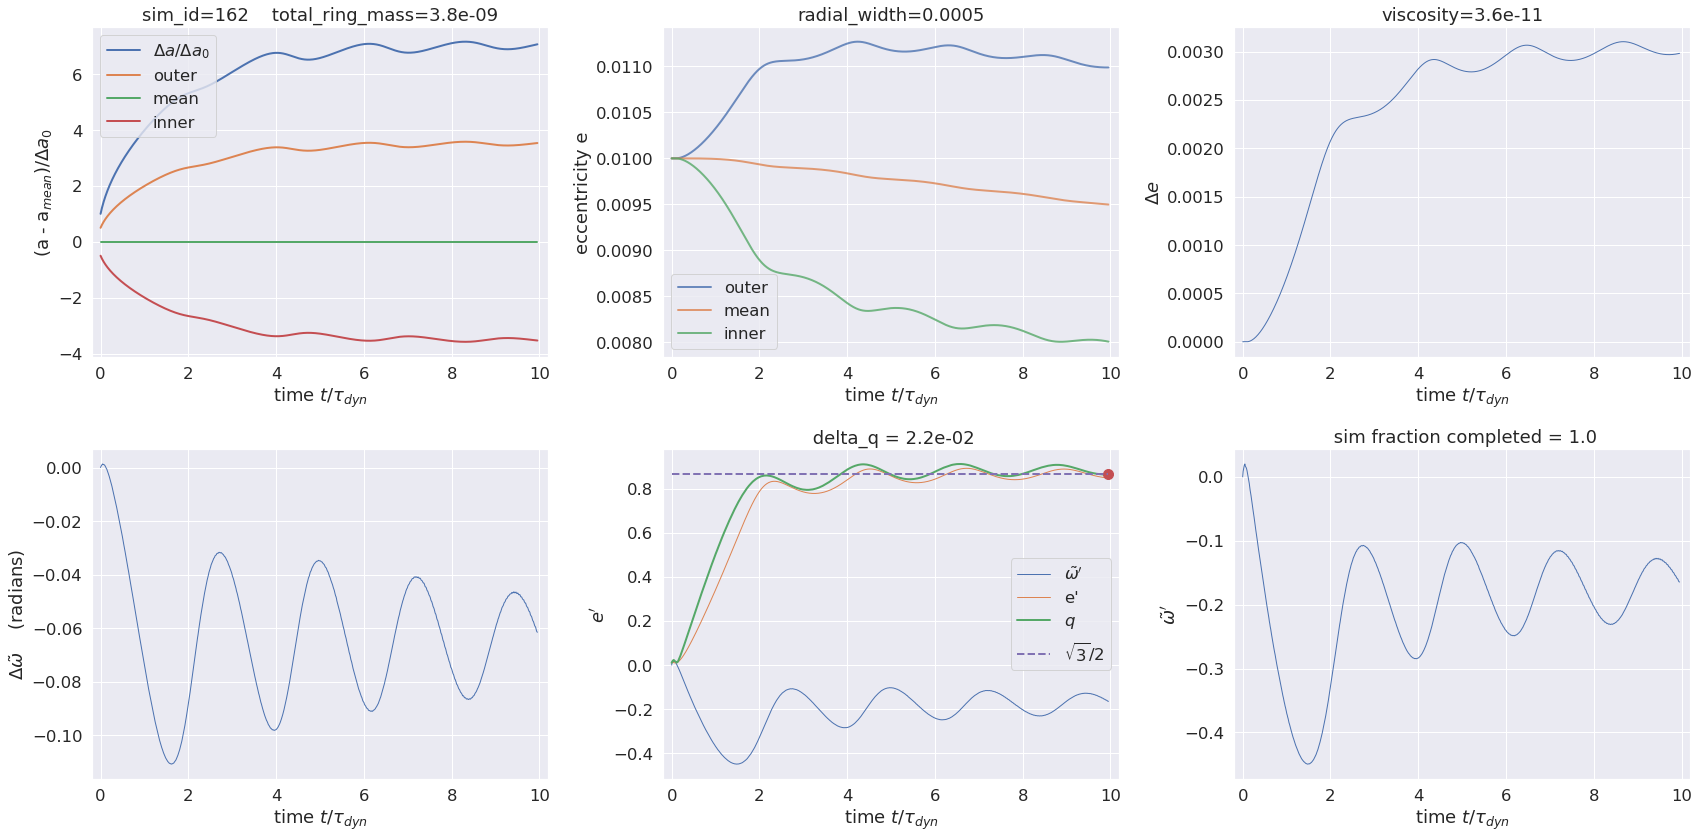

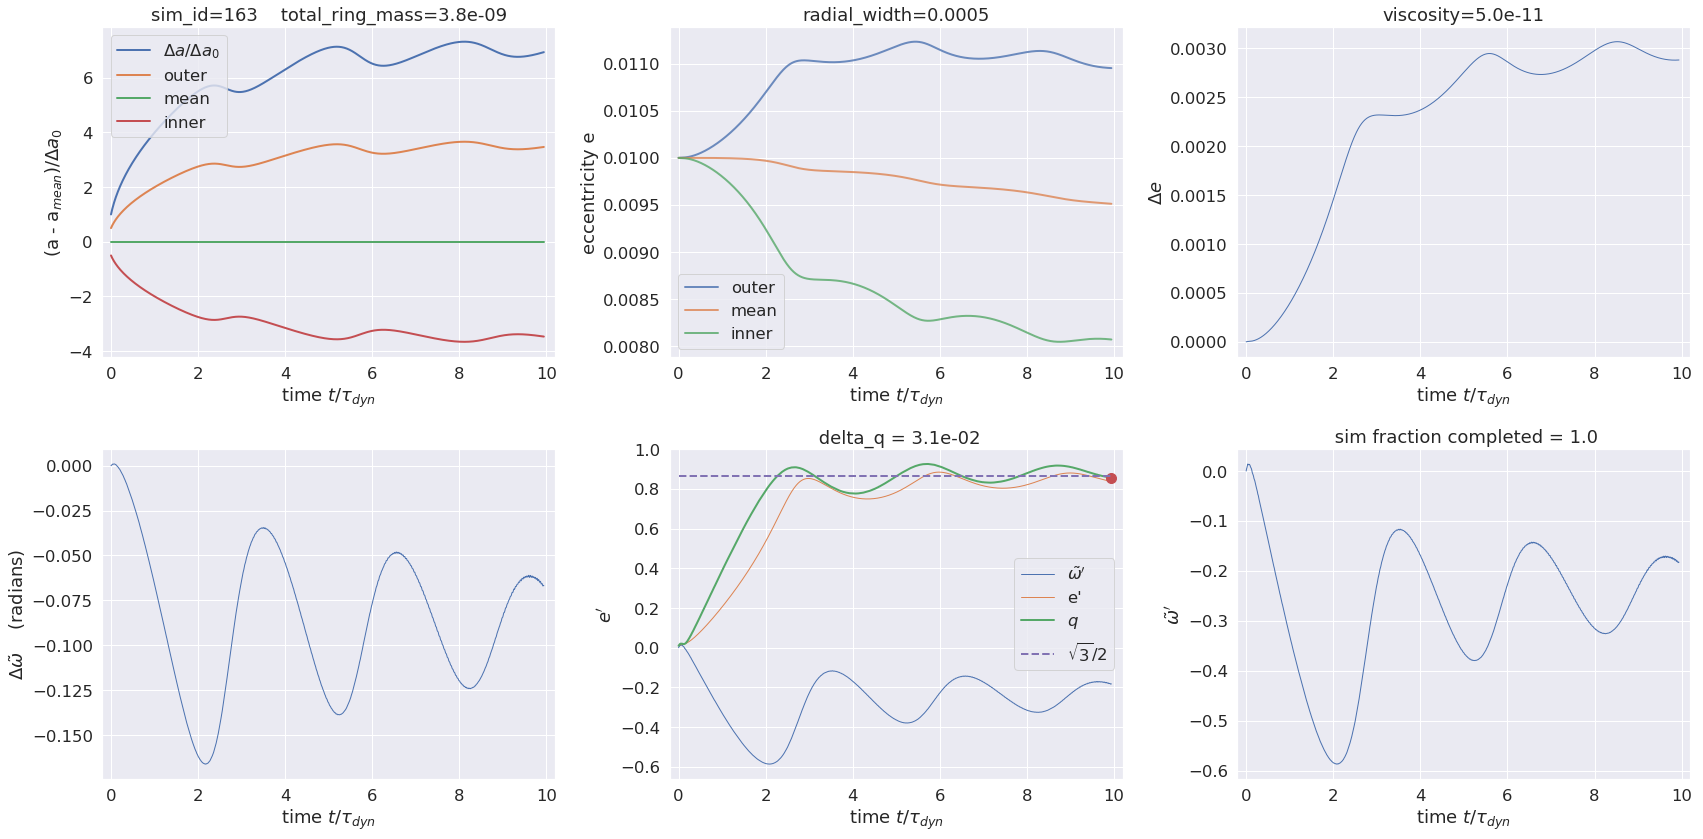

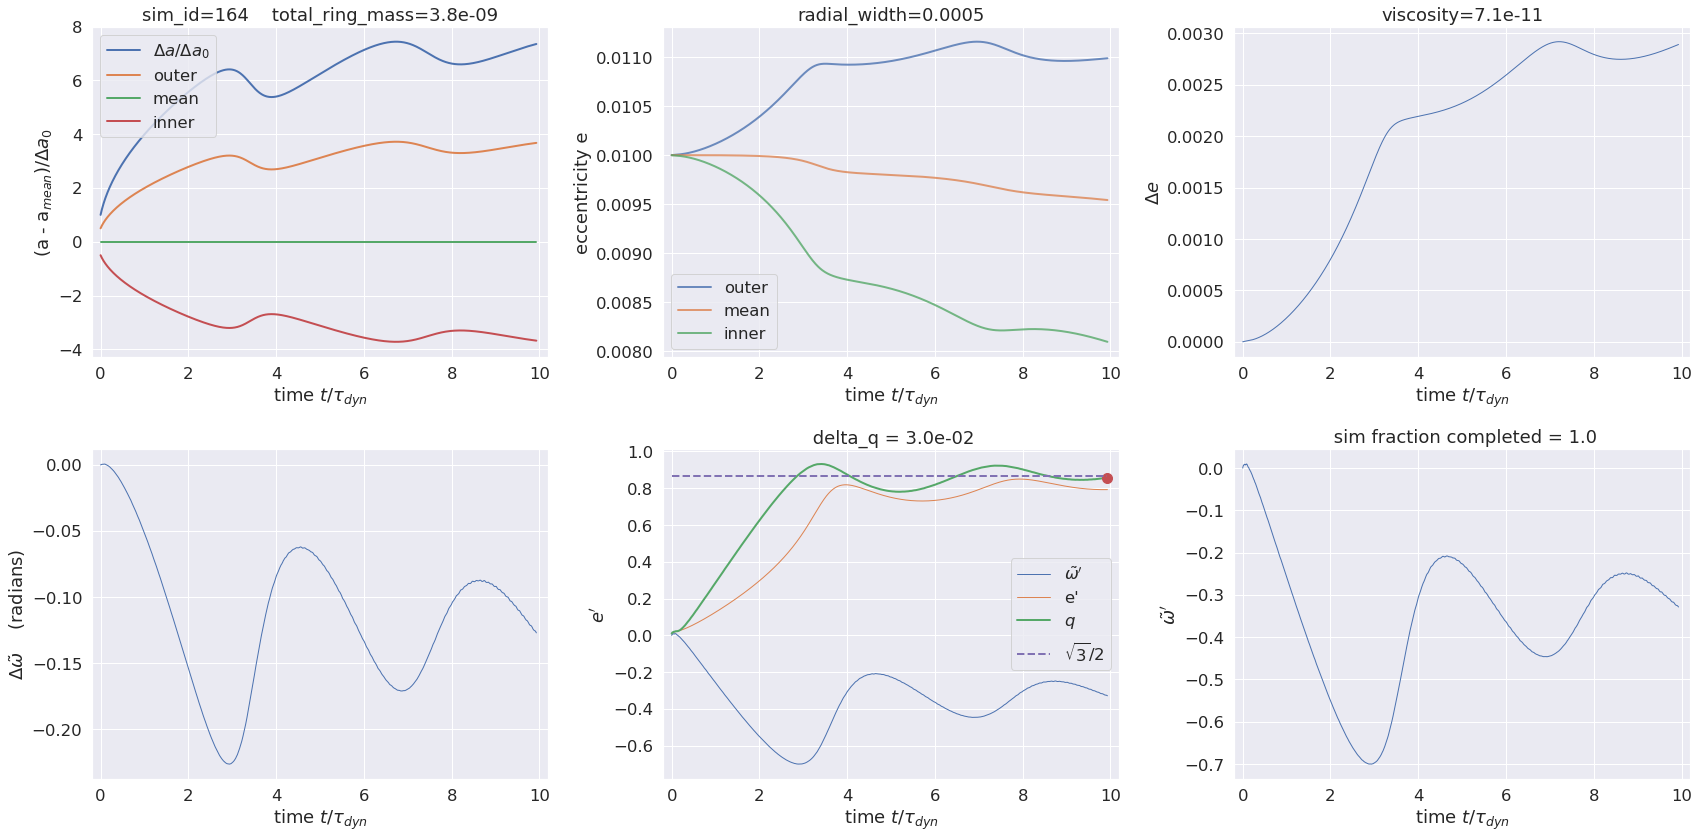

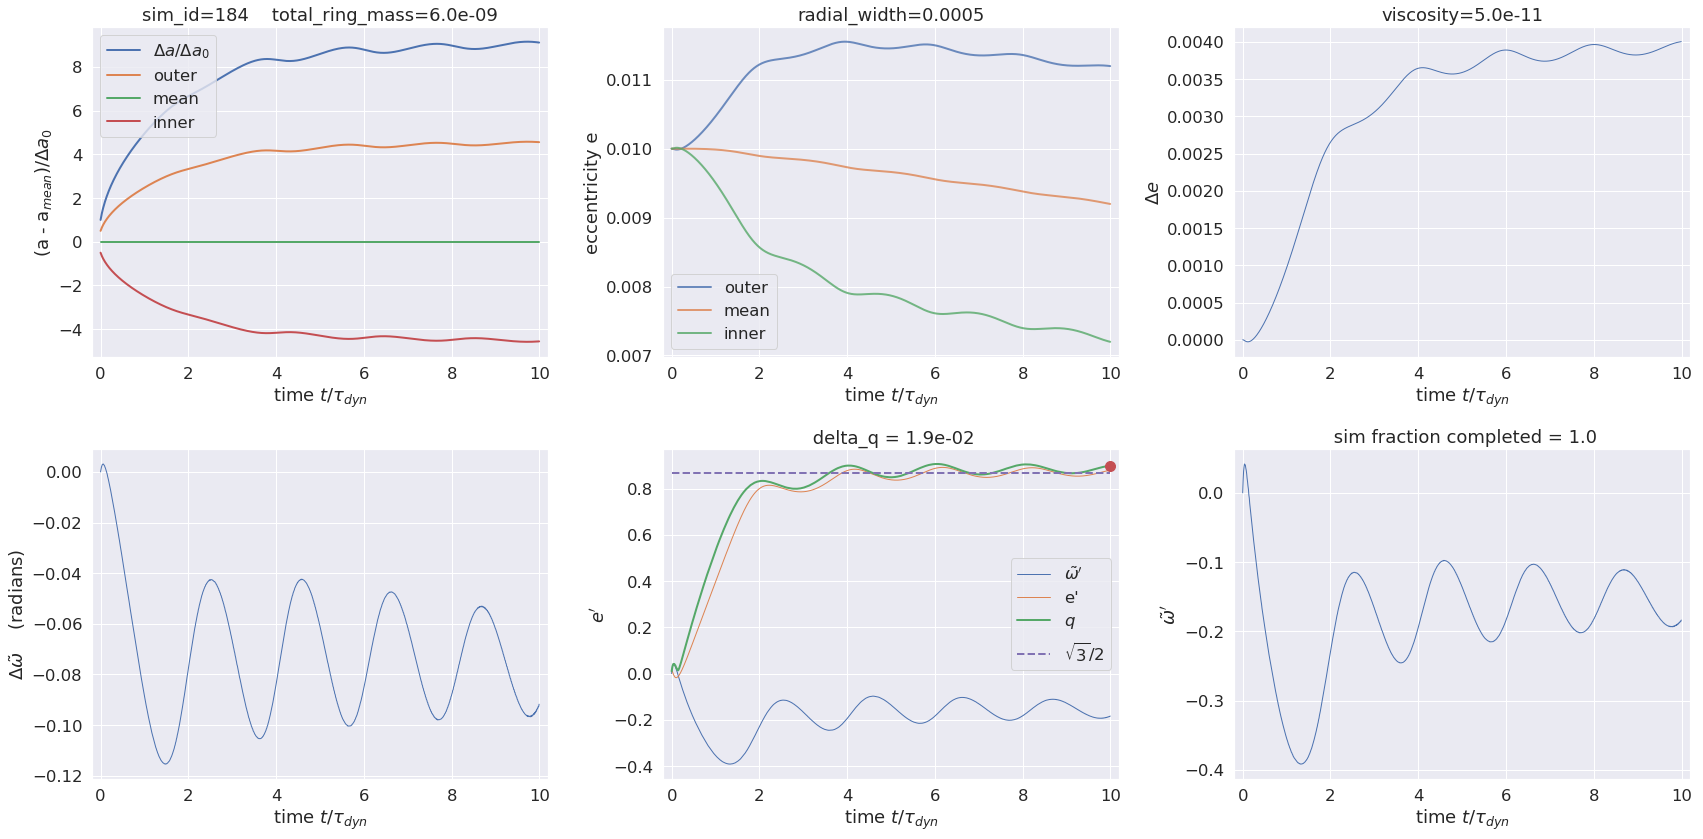

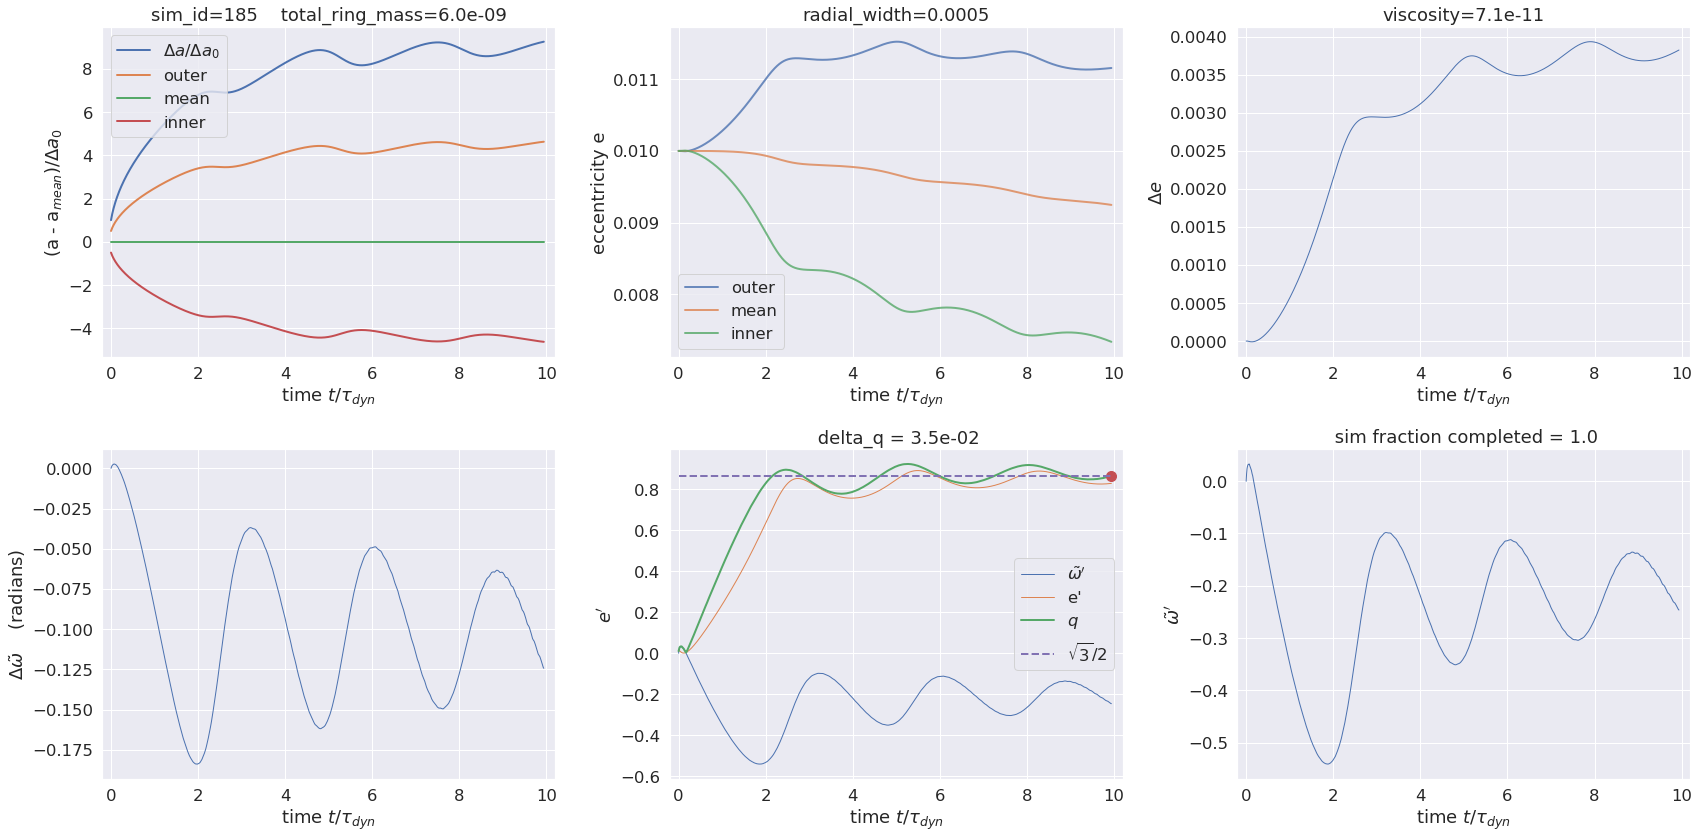

In [6]:
#generate grid of summary plots, for each sim that evolves to completion with low |wt_prime|
debug = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    d['times_dynamical_max'] = int(times_dynamical.max())
    
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    da_init = da[0]
    
    #compute e_prime, wt_prime, q to lowest order, and H(q)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    idx = (times_dynamical > 0.8*times_dynamical.max())
    d['q'] = q[idx].mean()
    d['delta_q'] = 0.5*(q[idx].max() - q[idx].min())
    d['wt_prime'] = wt_prime[idx].mean()
    
    #report on sims that execute without crossing streamlines
    if ((current_timestep == expected_timestep) and (np.abs(d['wt_prime']) < d['q']/2)):

        if (debug):
            print 'path = ', path
            print 'total_ring_mass = ', total_ring_mass
            print 'radial_width = ', radial_width
            print 'shear_viscosity = ', shear_viscosity
            print 'dynamical_timescale = ', dynamical_timescale
            print 'current, expected timesteps = ', current_timestep, expected_timestep
            print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0
        
        #create grid of plots
        sns.set(font_scale=1.5, font='DejaVu Sans')
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        
        #plot streamline's mutual a-evolution
        ax = axs[0][0]
        x = times_dynamical
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        title = 'sim_id=' + str(sim_id) + '    total_ring_mass=' + '{:.1e}'.format(total_ring_mass)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()

        #plot streamline's e-evolution
        ax = axs[0][1]
        x = times_dynamical
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot delta_e versus time
        ax = axs[0][2]
        x = times_dynamical
        y = de
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta e$')
        title = 'viscosity=' + '{:.1e}'.format(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot dwt versus time
        ax = axs[1][0]
        x = times_dynamical
        y = dwt
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot e_prime wt_prime and q versus time
        ax = axs[1][1]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        if (streamline_crossing_timestep == None):
            p = ax.plot(x[-1], y[-1], marker='o', markersize=10, label='')
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
        title = ' delta_q = ' + '{:.1e}'.format(d['delta_q'])
        p = ax.set_title(title)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot wt_prime versus time
        ax = axs[1][2]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        title = ' sim fraction completed = ' + str(current_timestep*1.0/expected_timestep)
        p = ax.set_title(title)

        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$\tilde{\omega}'$")
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
    
    data += [d]
df = pd.DataFrame(data)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'times_dynamical_max', 
    'total_ring_mass', 'radial_width', 'shear_viscosity', 'q', 'delta_q', 'wt_prime', 'path']
df = df[cols].sort_values('sim_id').reset_index(drop=True)
df_results = df

In [7]:
#list all sims that evolved into self-confining state
df = df_results
idx = (df.current_timestep == df.expected_timestep)
print 'fraction of sims that execute to completion = ', idx.sum()*1.0/len(idx)
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
print 'fraction of sims that evolve to self-confining state = ', idx.sum()*1.0/len(idx)
df[idx]

fraction of sims that execute to completion =  0.31797235023041476
fraction of sims that evolve to self-confining state =  0.15207373271889402


sim_id  expected_timestep  current_timestep  \
45       45            1102000           1102000   
46       46             780000            780000   
47       47             552000            552000   
48       48             391000            391000   
49       49             277000            277000   
68       68             876000            876000   
69       69             620000            620000   
70       70             439000            439000   
71       71             310000            310000   
72       72             220000            220000   
73       73             155000            155000   
91       91             695000            695000   
92       92             492000            492000   
93       93             348000            348000   
94       94             246000            246000   
95       95             174000            174000   
96       96             123000            123000   
114     114             552000            552000   
115     115             391000            391000   
116     116             277000            277000   
117     117             196000            196000   
118     118             138000            138000   
137     137             439000            439000   
138     138             310000            310000   
139     139             220000            220000   
140     140             155000            155000   
141     141             110000            110000   
161     161             246000            246000   
162     162             174000            174000   
163     163             123000            123000   
164     164              87000             87000   
184     184             196000            196000   
185     185             138000            138000   

     streamline_crossing_timestep  times_dynamical_max  total_ring_mass  \
45                            NaN                    9     3.767830e-10   
46                            NaN                    9     3.767830e-10   
47                            NaN                    9     3.767830e-10   
48                            NaN                    9     3.767830e-10   
49                            NaN                    9     3.767830e-10   
68                            NaN                    9     5.971608e-10   
69                            NaN                    9     5.971608e-10   
70                            NaN                    9     5.971608e-10   
71                            NaN                    9     5.971608e-10   
72                            NaN                    9     5.971608e-10   
73                            NaN                    9     5.971608e-10   
91                            NaN                    9     9.464360e-10   
92                            NaN                    9     9.464360e-10   
93                            NaN                    9     9.464360e-10   
94                            NaN                    9     9.464360e-10   
95                            NaN                    9     9.464360e-10   
96                            NaN                    9     9.464360e-10   
114                           NaN                    9     1.500000e-09   
115                           NaN                    9     1.500000e-09   
116                           NaN                    9     1.500000e-09   
117                           NaN                    9     1.500000e-09   
118                           NaN                    9     1.500000e-09   
137                           NaN                    9     2.377340e-09   
138                           NaN                    9     2.377340e-09   
139                           NaN                    9     2.377340e-09   
140                           NaN                    9     2.377340e-09   
141                           NaN                    9     2.377340e-09   
161                           NaN                    9     3.767830e-09   
162                           NaN                    9     3.

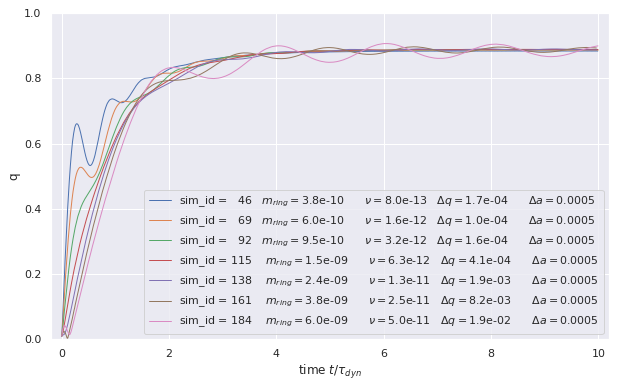

In [8]:
#for selected sim_ids, plot q(t/t_dyn) for the sim whose viscosity yielded lowest delta_q
df = df_results
sim_ids = [46, 69, 92, 115, 138, 161, 184]
xlim = (-0.2, 10.2)
ylim = (0.0, 1.0)
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
data = []
for sim_id in sim_ids:
    #for each total_ring_mass, find the sim whose viscosity yields lowest delta_q
    idx = (df.current_timestep == df.expected_timestep) & (df.sim_id == sim_id) & (df.wt_prime.abs() < df.q/2)
    dfs = df[idx]
    try:
        idx = dfs.delta_q.idxmin()
        dfss = dfs.loc[idx]
        path = dfss.path
        sim_id = dfss.sim_id
        delta_q = dfss.delta_q
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
        dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0005)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot e_prime wt_prime and q versus time
        x = times_dynamical
        y = q
        sim_id_str = str(sim_id)
        if (len(sim_id_str) < 3): sim_id_str = '  ' + sim_id_str + '  '
        label = 'sim_id = ' + sim_id_str
        label += '\t' + r'$m_{ring}=$' + '{:.1e}'.format(total_ring_mass)
        label += '\t' + r'$\nu=$' + '{:.1e}'.format(shear_viscosity)
        label += '\t' + r'$\Delta q=$' + '{:.1e}'.format(delta_q)
        label += '\t' + r'$\Delta a =$' + str(radial_width)
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=label)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('q')
        p = ax.set_xlim(xlim)
        p = ax.set_ylim(ylim)
        p = ax.legend()
        data += [dfss.to_dict()]
    except:
        pass

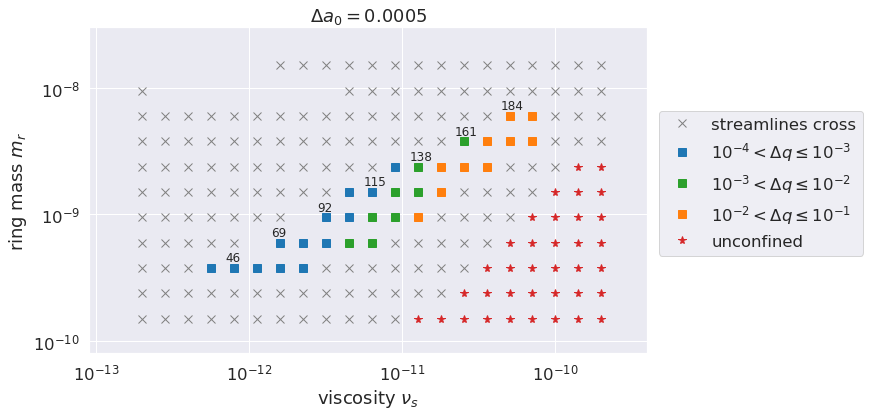

In [9]:
#show grid of simulation outcomes
df = df_results
delta_qs = [(1.0e-4, 1.0e-3, r'$10^{-4}<\Delta q\leq10^{-3}$', color_seq[0]), 
    (1.0e-3, 1.0e-2, r'$10^{-3}<\Delta q\leq10^{-2}$', color_seq[2]), 
    (1.0e-2, 1.0e-1, r'$10^{-2}<\Delta q\leq10^{-1}$', color_seq[1])]
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
#indicate sims that didnt complete
idx = (df.current_timestep < df.expected_timestep)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='streamlines cross')
#self confining sims
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
dfs = df[idx]
for delta_q_min, delta_q_max, label, color in delta_qs:
    idx = ((dfs.delta_q > delta_q_min) & (dfs.delta_q <= delta_q_max))
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='s', markersize=8, label=label, color=color)
#sims that complete but dont self-confine
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() > df.q/2)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
color = color_seq[3]
p = ax.plot(xp, yp, linestyle='none', marker='*', markersize=8, color=color, label='unconfined')
#label sims appearing in above plot
for sim_id in sim_ids:
    idx = (df.sim_id == sim_id)
    dfs = df[idx]
    try:
        xp = dfs.shear_viscosity.values[0]
        yp = dfs.total_ring_mass.values[0]
        xy = (0.88*xp, 1.13*yp)
        p = ax.annotate(sim_id, xy, fontsize=12)
    except:
        pass
p = ax.set_xscale('log')
p = ax.set_yscale('log')
p = ax.set_xlabel(r'viscosity $\nu_s$')
p = ax.set_ylabel(r'ring mass $m_r$')
radial_width = str(df.radial_width.max())
title = r'$\Delta a_0 = $' + str(radial_width)
p = ax.set_title(title)
p = ax.set_xlim(9.0e-14, 4.0e-10)
p = ax.set_ylim(8.0e-11, 3.0e-8)
p = ax.legend(loc=(1.02, 0.3))

In [10]:
df = df_results
print 'total_ring_mass = ', df.total_ring_mass.unique()
print 'radial_width = ', df.radial_width.unique()
print 'shear_viscosity = ', df.shear_viscosity.unique()

total_ring_mass =  [1.50000000e-10 2.37733979e-10 3.76782965e-10 5.97160756e-10
 9.46436017e-10 1.50000000e-09 2.37733979e-09 3.76782965e-09
 5.97160756e-09 9.46436017e-09 1.50000000e-08]
radial_width =  [0.0005]
shear_viscosity =  [2.00000000e-13 2.82507509e-13 3.99052463e-13 5.63676586e-13
 7.96214341e-13 1.12468265e-12 1.58865647e-12 2.24403691e-12
 3.16978638e-12 4.47744228e-12 6.32455532e-12 8.93367184e-12
 1.26191469e-11 1.78250188e-11 2.51785082e-11 3.55655882e-11
 5.02377286e-11 7.09626778e-11 1.00237447e-10 1.41589157e-10
 2.00000000e-10]
